### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle
import itertools
import matplotlib.pyplot as plt

### Data

In [3]:
# What to change for PMG 287 whole mixture:

# mixture_paths['PMG 287 monitoring'] = '../data/PMG_287/preprocessed_mixture_whole.csv'
# (instead of '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv')

# results_paths['PMG 287 monitoring'] = '../results/PMG_287/whole_spectrum_of_mixture/'
# (instead of '../results/PMG_287/cut_spectrum_of_mixture/')

# how_to_divide = 'whole spectrum' in 'Loading integrals computed in MNova' section
# (instead of 'sum')

# how_to_divide = 'whole spectrum' in 'Loading integrals computed in Python' section
# (instead of 'sum')

#optionally add ylim(0,0.4) in plots

In [4]:
experiment_name = 'PMG 284 monitoring'

In [18]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                       '../data/PMG_287/preprocessed_triethylsilane.csv',
                                       '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                 'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/cut_spectrum_of_mixture/'}

substances_names = {'Saccharose hydrolysis': ['sucrose', 'alpha-glucose', 'beta-glucose', 'fructose'],
                    'PMG 284 monitoring': ['2-pentene', 'triethylsilane', 'products'],
                    'PMG 287 monitoring': ['1-hexene', 'triethylsilane', 'product']
                   }

integrals_to_compare_with = {'Saccharose hydrolysis': '../mnova_integrals/sacharoza_calki_nowe.csv',
                    'PMG 284 monitoring': '../mnova_integrals/284_edited_corrected_calki.csv',
                    'PMG 287 monitoring': '../mnova_integrals/287_calki_zsumowane.csv'
                            }

integrals_separators = {'Saccharose hydrolysis': '\t',
                    'PMG 284 monitoring': ',',
                    'PMG 287 monitoring': ';'
                            }

python_integrals_to_compare_with = {'Saccharose hydrolysis': '../python_integrals/python_integral_Saccharose_hydrolysis.csv',
                    'PMG 284 monitoring': '../python_integrals/python_integral_PMG_284_monitoring.csv',
                    'PMG 287 monitoring': '../python_integrals/python_integral_PMG_287_monitoring.csv'
                            }

python_integrals_separators = {'Saccharose hydrolysis': ',',
                    'PMG 284 monitoring': ',',
                    'PMG 287 monitoring': ','
                            }

colors_for_components = {'Saccharose hydrolysis': ['#f5cacc', '#e2eac4', '#c0f5ce', '#c4f1ef'],
                         'PMG 284 monitoring': ['#f5cacc', '#e2eac4', '#c0f5ce'],
                        'PMG 287 monitoring': ['#b9dbf3', '#ffdec2', '#bbecbb']
                        }

saturated_colors_for_components = {'Saccharose hydrolysis': ['#e07676', '#b3ba97', '#88c398', '#2bbcb7'],
                         'PMG 284 monitoring': ['#e07676', '#b3ba97', '#88c398'],
                        'PMG 287 monitoring': ['blue', 'orange', 'green']
                        }

### Finding all values of kappa, kappa_th

In [6]:
def convert(txt):
    k = float(txt)
    if k%1 ==0:
        return int(k)
    return k

In [7]:
all_kappas = []
all_kappas_th = []
for file in os.listdir(results_paths[experiment_name]):
    if file.startswith('noise_proportions_in_times'):
        kappa = convert(file.split('_')[4])
        all_kappas.append(kappa)
        kappa_th = convert(file.split('_')[5][:-4])
        all_kappas_th.append(kappa_th)
        
all_kappas = sorted(list(set(all_kappas)))
all_kappas_th = sorted(list(set(all_kappas_th)))

In [8]:
kappas_to_remove = [1.2, 0.75]
kappas_th_to_remove = [1.2, 0.75]

In [9]:
all_kappas = sorted(list(set(all_kappas) - set(kappas_to_remove)))
all_kappas_th = sorted(list(set(all_kappas_th) - set(kappas_th_to_remove)))

In [10]:
all_kappas

[0.1, 0.25, 0.5, 1]


### Reading results for different values of kappa, kappa_th

In [11]:
results_dict = {}

for kappa in all_kappas:
    for kappa_th in all_kappas_th:
        try:
            with open(results_paths[experiment_name] + 'proportions_in_times_' +
                                  str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
                y = pickle.load(f)
                y = np.array(y)
                results_dict[(kappa, kappa_th)] = y
        except FileNotFoundError:
            results_dict[(kappa, kappa_th)] = None

### Loading integrals computed in MNova

In [12]:
integrals = pd.read_csv(integrals_to_compare_with[experiment_name], sep=integrals_separators[experiment_name])
how_to_divide = 'sum' #/ 'whole spectrum'

if experiment_name == 'Saccharose hydrolysis':
    integrals = integrals.iloc[1:,:]
    integrals.columns = ['saccharose', 'alpha-glucose', 'beta-glucose', 'fructose']
    integrals = integrals.apply(pd.to_numeric)
    nominator = np.array(integrals[['saccharose', 'alpha-glucose', 'beta-glucose', 'fructose']])
    if how_to_divide == 'whole spectrum':
        denominator = np.array(integrals[['whole spectrum']])
    elif how_to_divide == 'sum':
        denominator = np.array(integrals[['saccharose', 'alpha-glucose', 
                                          'beta-glucose', 'fructose']]).sum(axis=1).reshape(-1,1)
    mnova_integrals_proportions = nominator/denominator
    
if experiment_name == 'PMG 284 monitoring':
    integrals = integrals.iloc[1:,[2,6,8,10]]
    integrals.rename(columns={'Y(X)': 'penten',
                             'Y2(X)': 'silan',
                             'Y3(X)': 'produkt',
                             'Unnamed: 10': 'cale widmo'}, inplace=True)
    integrals = integrals[['penten', 'silan', 'produkt', 'cale widmo']]
    integrals = integrals.apply(pd.to_numeric)
    nominator = np.array(integrals[['penten', 'silan', 'produkt']])
    if how_to_divide == 'whole spectrum':
        denominator = np.array(integrals[['cale widmo']])
    elif how_to_divide == 'sum':
        denominator = np.array(integrals[['penten', 'silan', 'produkt']]).sum(axis=1).reshape(-1,1)
    mnova_integrals_proportions = nominator/denominator
    
if experiment_name == 'PMG 287 monitoring':
    integrals = integrals[['hexene sum', 'silane sum', 'product sum', 'all']].iloc[1:]
    for col in integrals.columns:
        integrals[col] = integrals[col].apply(lambda x: float(x.replace(',', '.')))
        
    nominator = np.array(integrals[['hexene sum', 'silane sum', 'product sum']])
    if how_to_divide == 'whole spectrum':
        denominator = np.array(integrals[['all']])
    elif how_to_divide == 'sum':
        denominator = np.array(integrals[['hexene sum', 'silane sum', 'product sum']]).sum(axis=1).reshape(-1,1)
    mnova_integrals_proportions = nominator/denominator

### Loading integrals computed in Python

In [13]:
integrals = pd.read_csv(python_integrals_to_compare_with[experiment_name], 
                        sep=python_integrals_separators[experiment_name])
how_to_divide = 'sum' #'whole spectrum'

if experiment_name == 'Saccharose hydrolysis':
    integrals = integrals.apply(pd.to_numeric)
    nominator = np.array(integrals.iloc[:,:4])
    if how_to_divide == 'whole spectrum':
        denominator = np.array(integrals[['whole_spectrum']])
    elif how_to_divide == 'sum':
        denominator = np.array(integrals.iloc[:,:4].sum(axis=1)).reshape(-1,1)
    python_integrals_proportions = nominator/denominator
    
if experiment_name == 'PMG 284 monitoring':
    integrals = integrals.apply(pd.to_numeric)
    nominator = np.array(integrals.iloc[:,:3])
    if how_to_divide == 'whole spectrum':
        denominator = np.array(integrals[['whole_spectrum']])
    elif how_to_divide == 'sum':
        denominator = np.array(integrals.iloc[:,:3]).sum(axis=1).reshape(-1,1)
    python_integrals_proportions = nominator/denominator
    
if experiment_name == 'PMG 287 monitoring':
    integrals = integrals.apply(pd.to_numeric)
    nominator = np.array(integrals.iloc[:,:3])
    if how_to_divide == 'whole spectrum':
        denominator = np.array(integrals[['whole_spectrum']])
    elif how_to_divide == 'sum':
        denominator = np.array(integrals.iloc[:,:3]).sum(axis=1).reshape(-1,1)
    python_integrals_proportions = nominator/denominator

### Setting time for particular experiments

In [14]:
time_range = {
                'Saccharose hydrolysis': [5*(el-1) for el in list(range(1,1023,10))],
                'PMG 284 monitoring': [5*(el-1) for el in list(range(1,1000,10))],
                'PMG 287 monitoring': [5*(el-1) for el in list(range(1,1000,10))]
}

time_range_integrals_python = {
                'Saccharose hydrolysis': [5*(el-1) for el in list(range(1,1025))],
                'PMG 284 monitoring': [5*(el-1) for el in list(range(1,1000))],
                'PMG 287 monitoring': [5*(el-1) for el in list(range(1,1000))]
}

time_range_integrals_mnova = {
                'Saccharose hydrolysis': [5*(el-1) for el in list(range(1,1023))],
                'PMG 284 monitoring': [5*(el-1) for el in list(range(1,1001))],
                'PMG 287 monitoring': [5*(el-1) for el in list(range(1,1001))]
}

### Visualising results for different parameters, different components

In [15]:
component_nr = 0

In [16]:
lin_regr = False

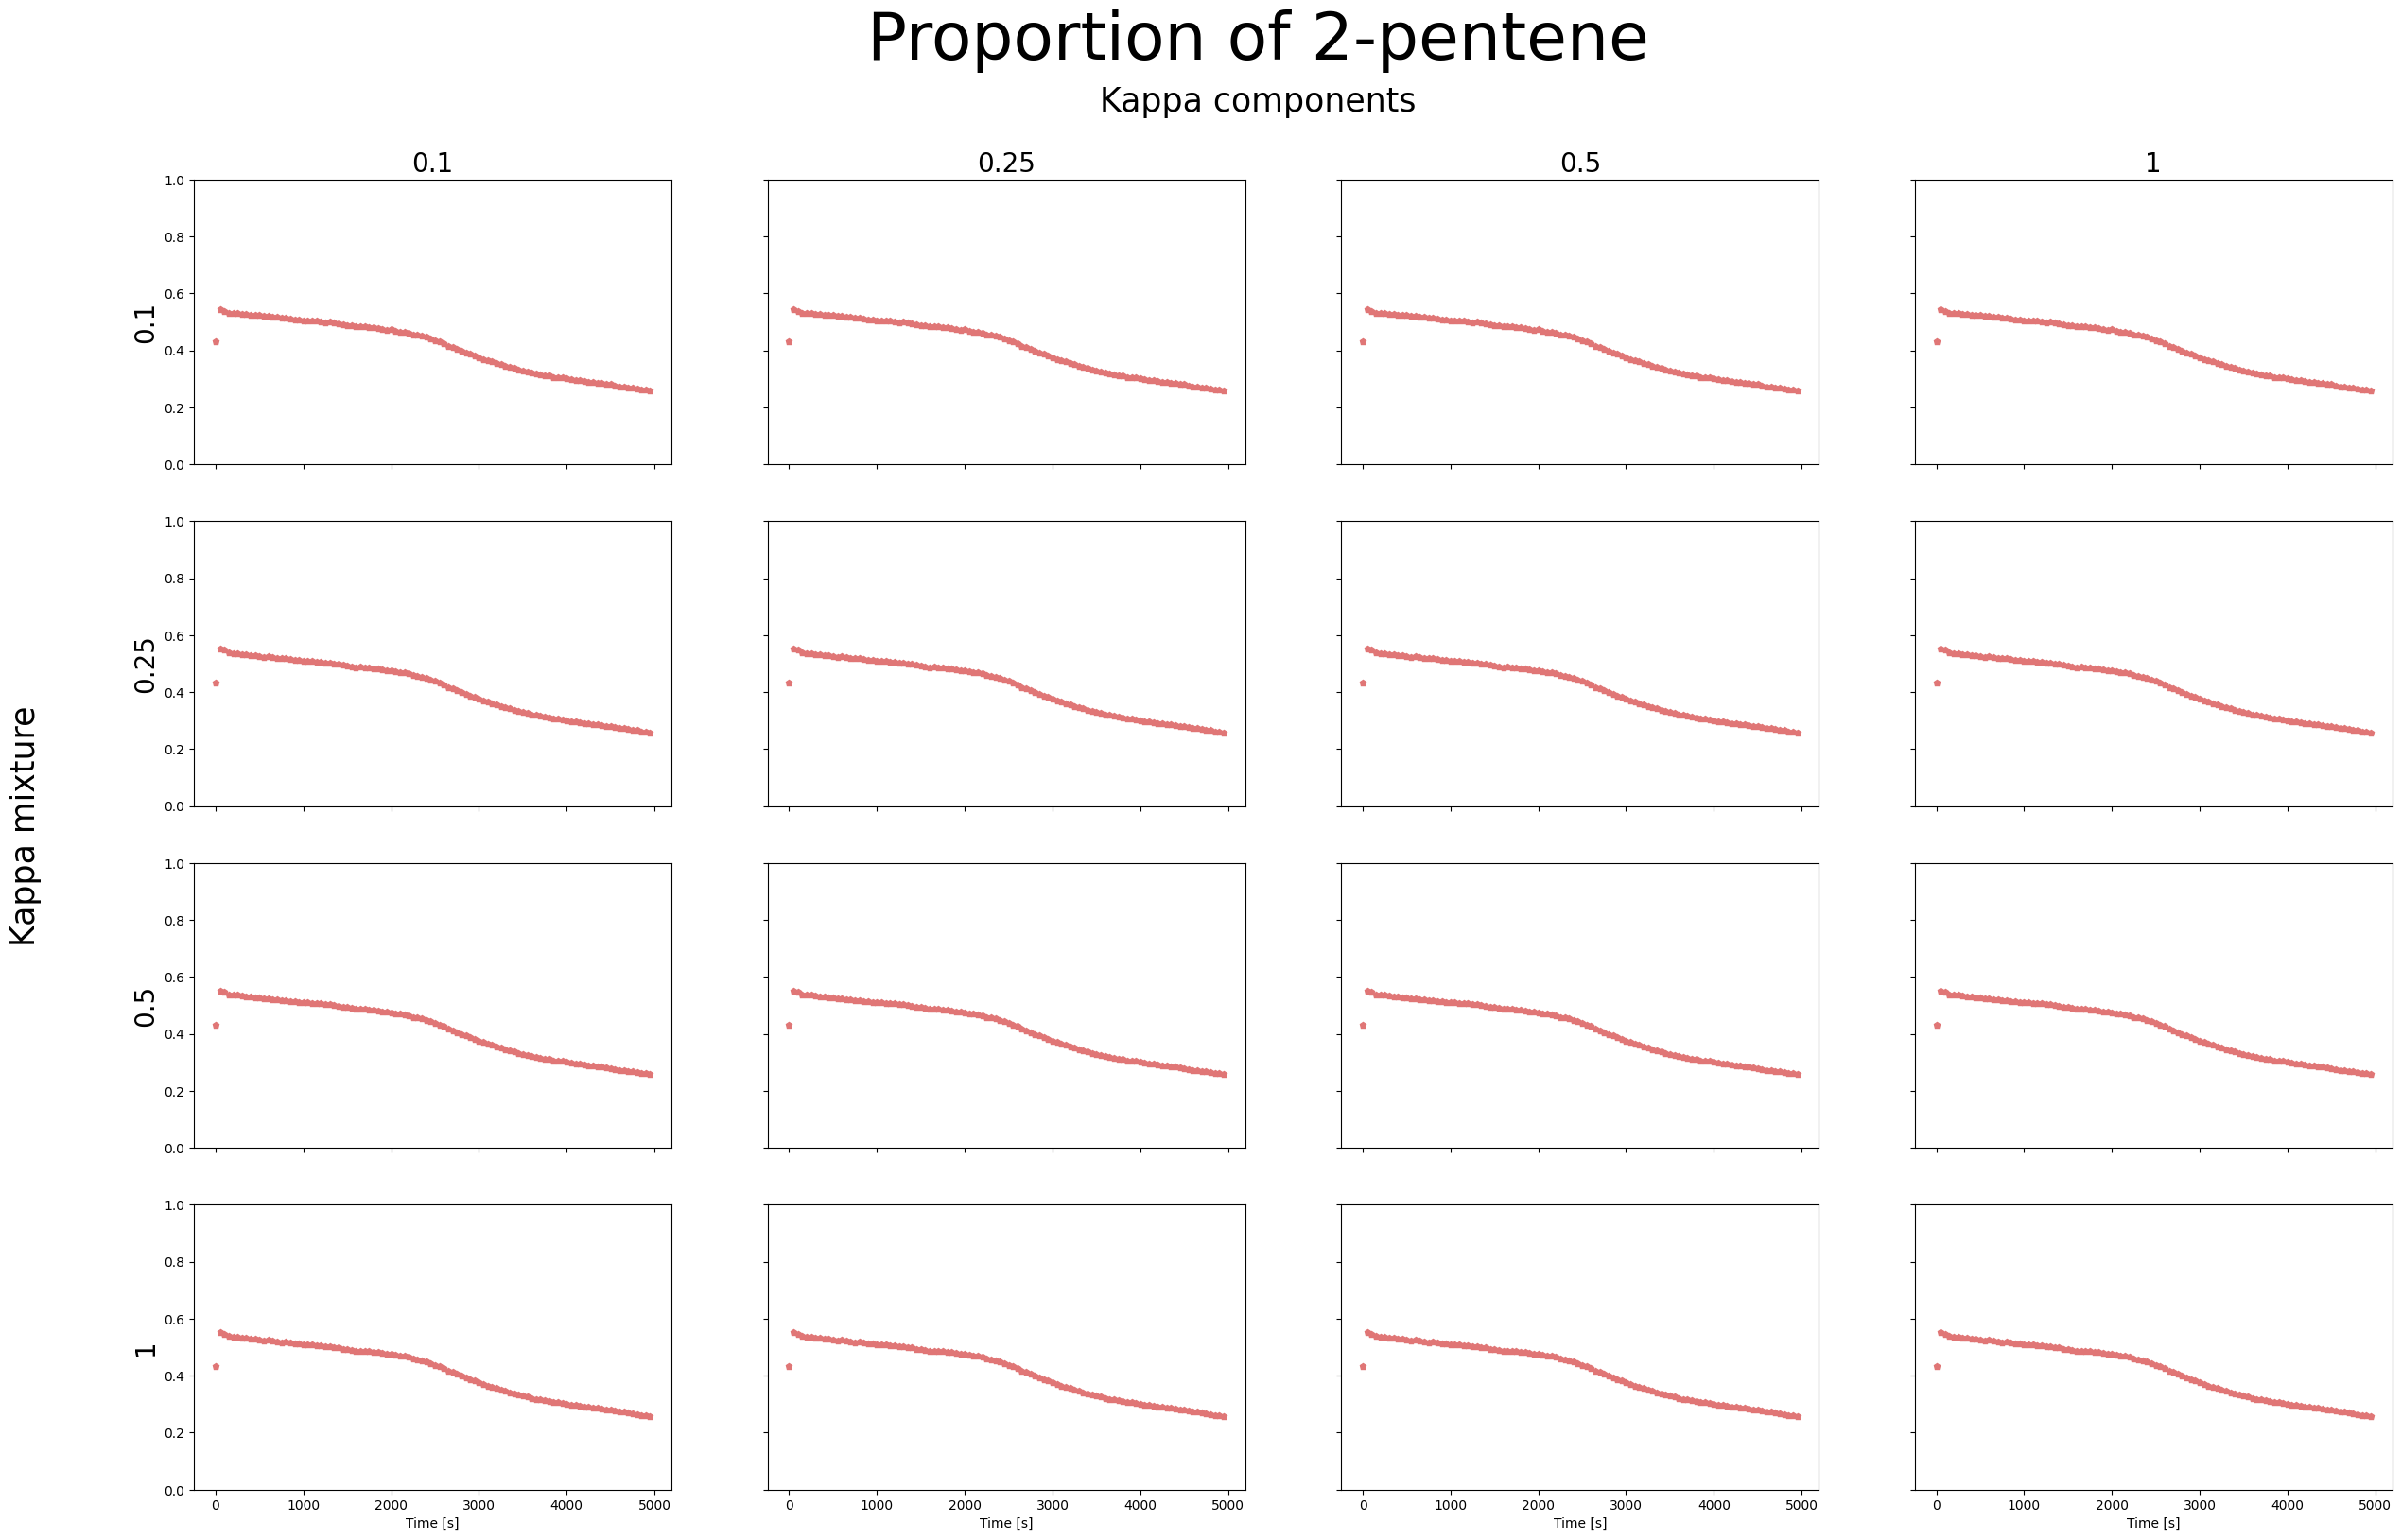

In [19]:
fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of ' + substances_names[experiment_name][component_nr], fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = results_dict[(kappa, kappa_th)][:, component_nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5, 
                     color=saturated_colors_for_components[experiment_name][component_nr])
            if lin_regr:
                t = np.array(time_range[experiment_name])
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(time_range[experiment_name], slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)
    
for ax, col in zip(axs[-1], cols):
    ax.set_xlabel('Time [s]', size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_'+ substances_names[experiment_name][component_nr]+'.png')

### Visualising results for different parameters, all components together

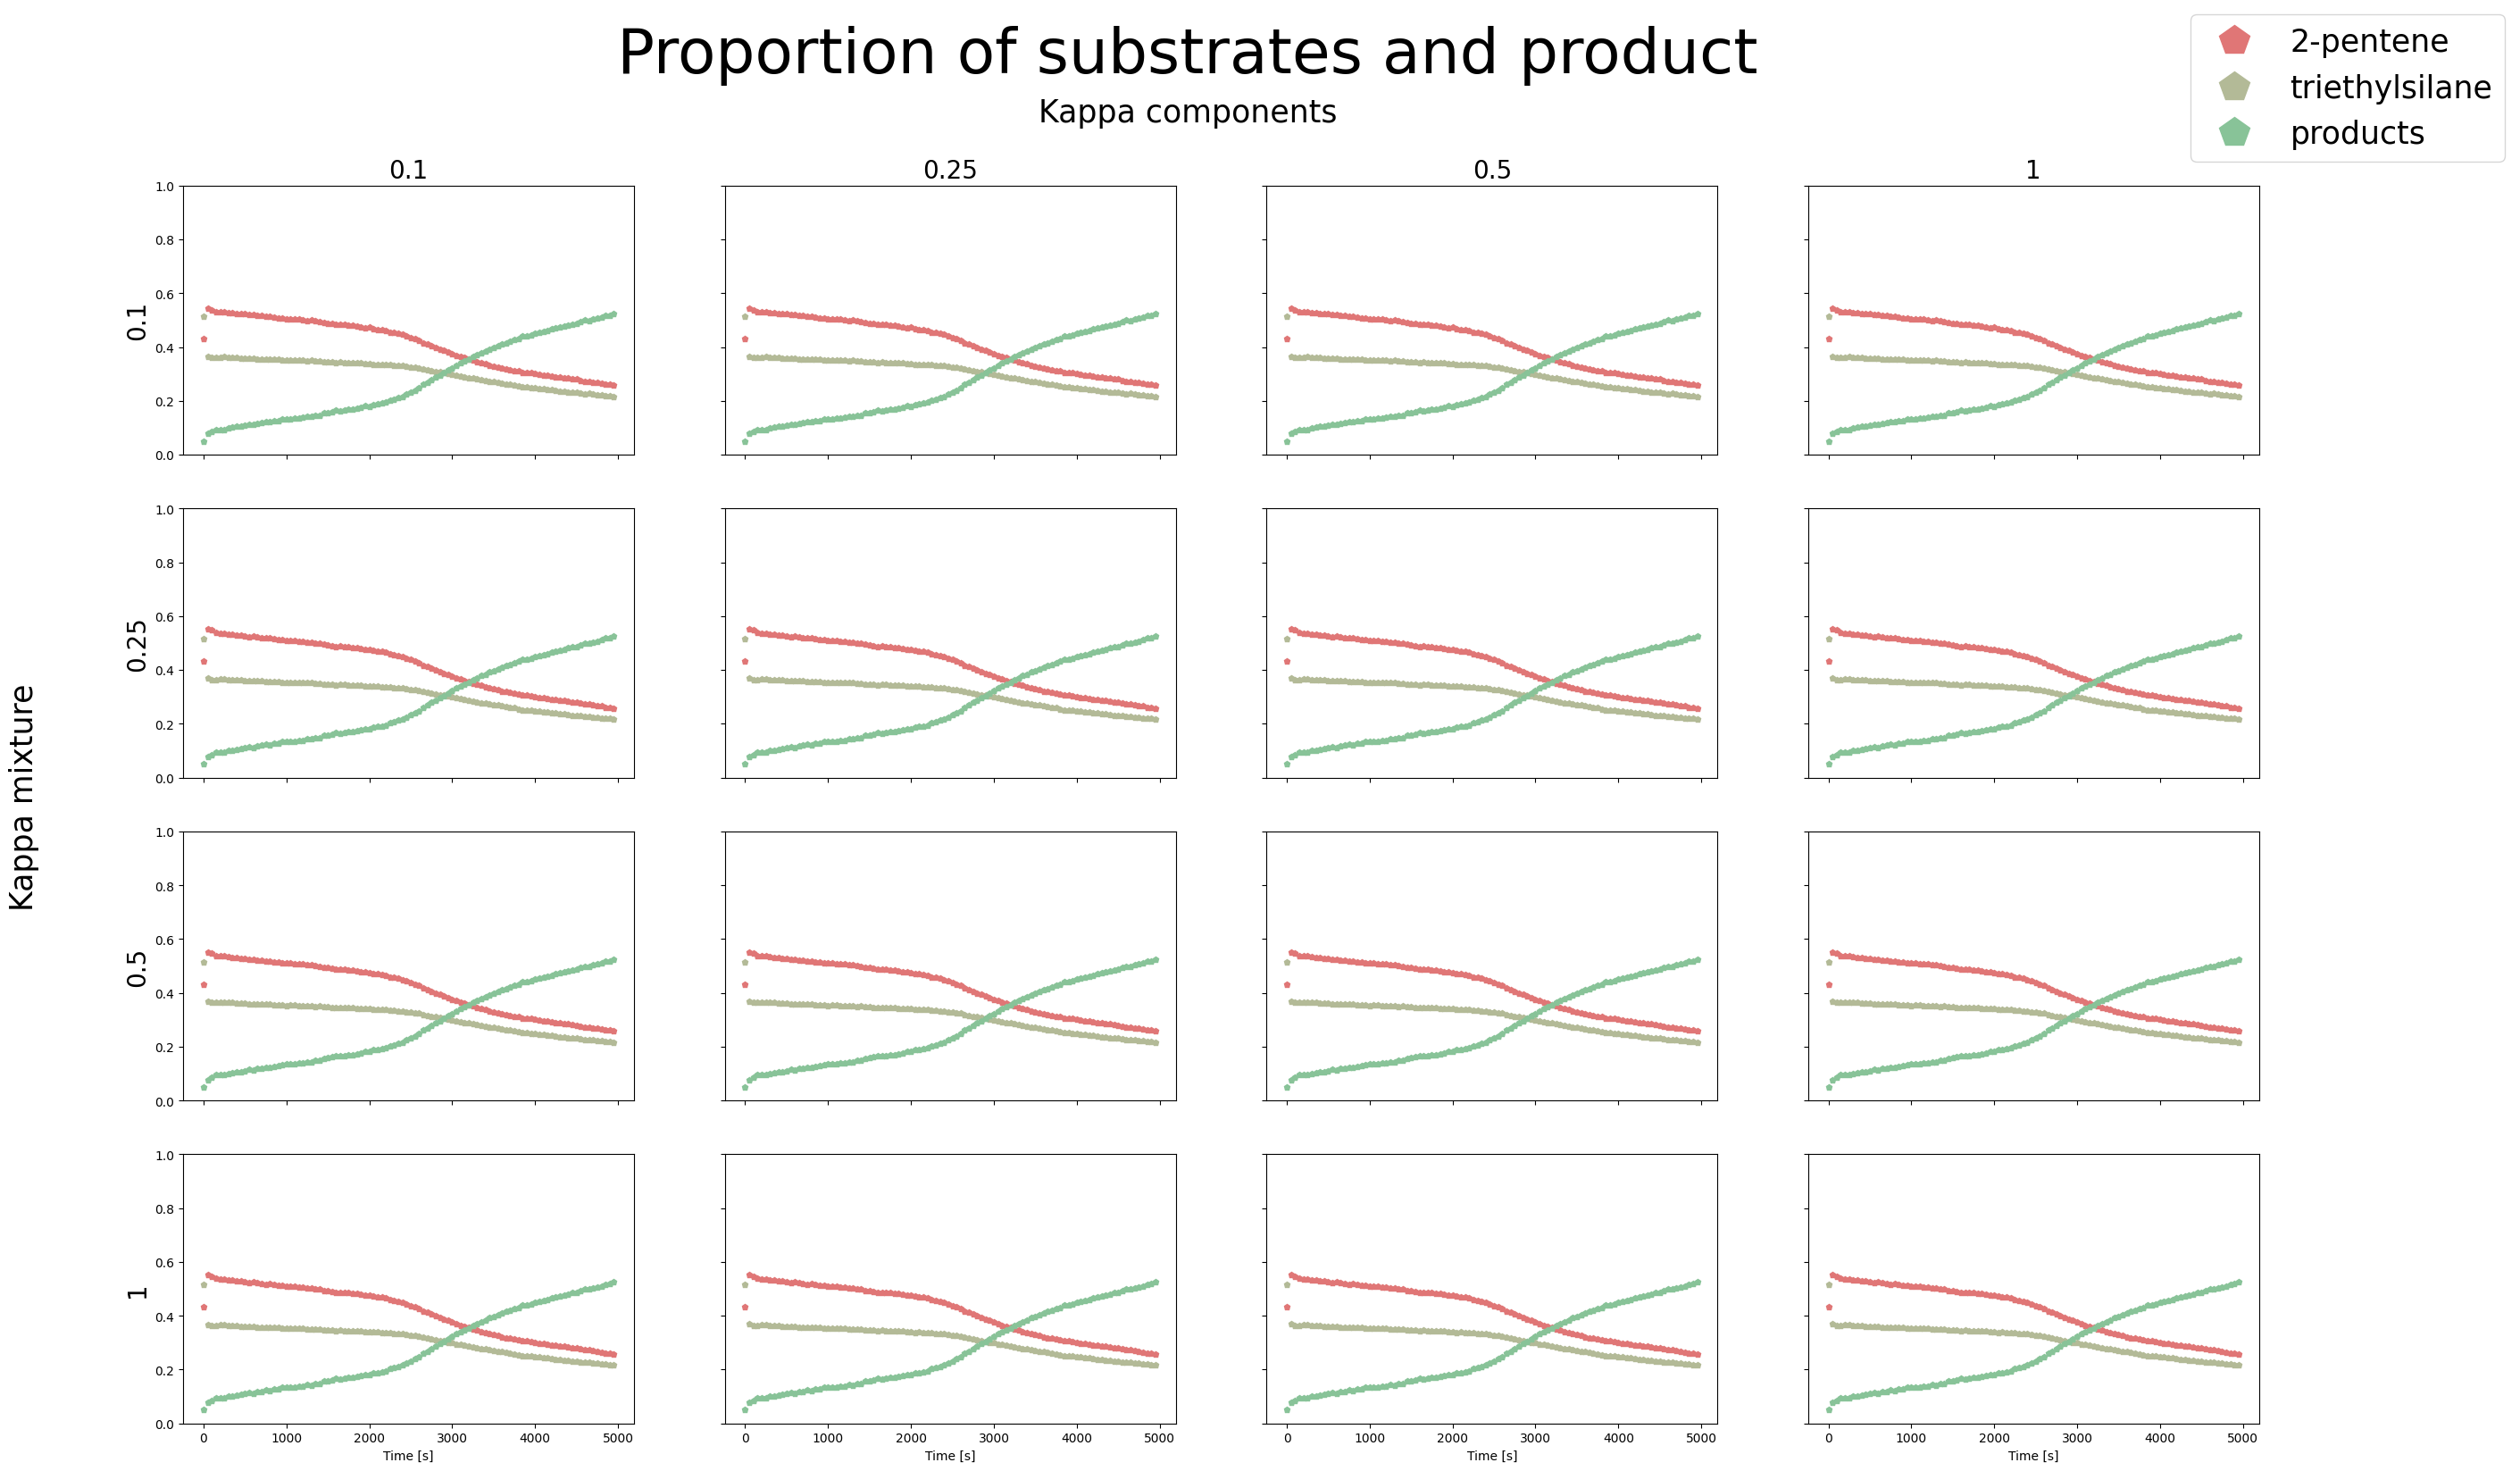

In [20]:
fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of substrates and product', fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = results_dict[(kappa, kappa_th)]
            for i in range(y.shape[1]):
                axx.plot(time_range[experiment_name], y[:,i], 'p', markersize=5, 
                         label=substances_names[experiment_name][i],
                        color=saturated_colors_for_components[experiment_name][i])
        except TypeError:
            axx.plot(0,0)
        except AttributeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)
    
for ax, col in zip(axs[-1], cols):
    ax.set_xlabel('Time [s]', size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', prop={'size': 25}, markerscale=5)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_components_separately.png')

### Visualising results for different parameters, all components together + integrals

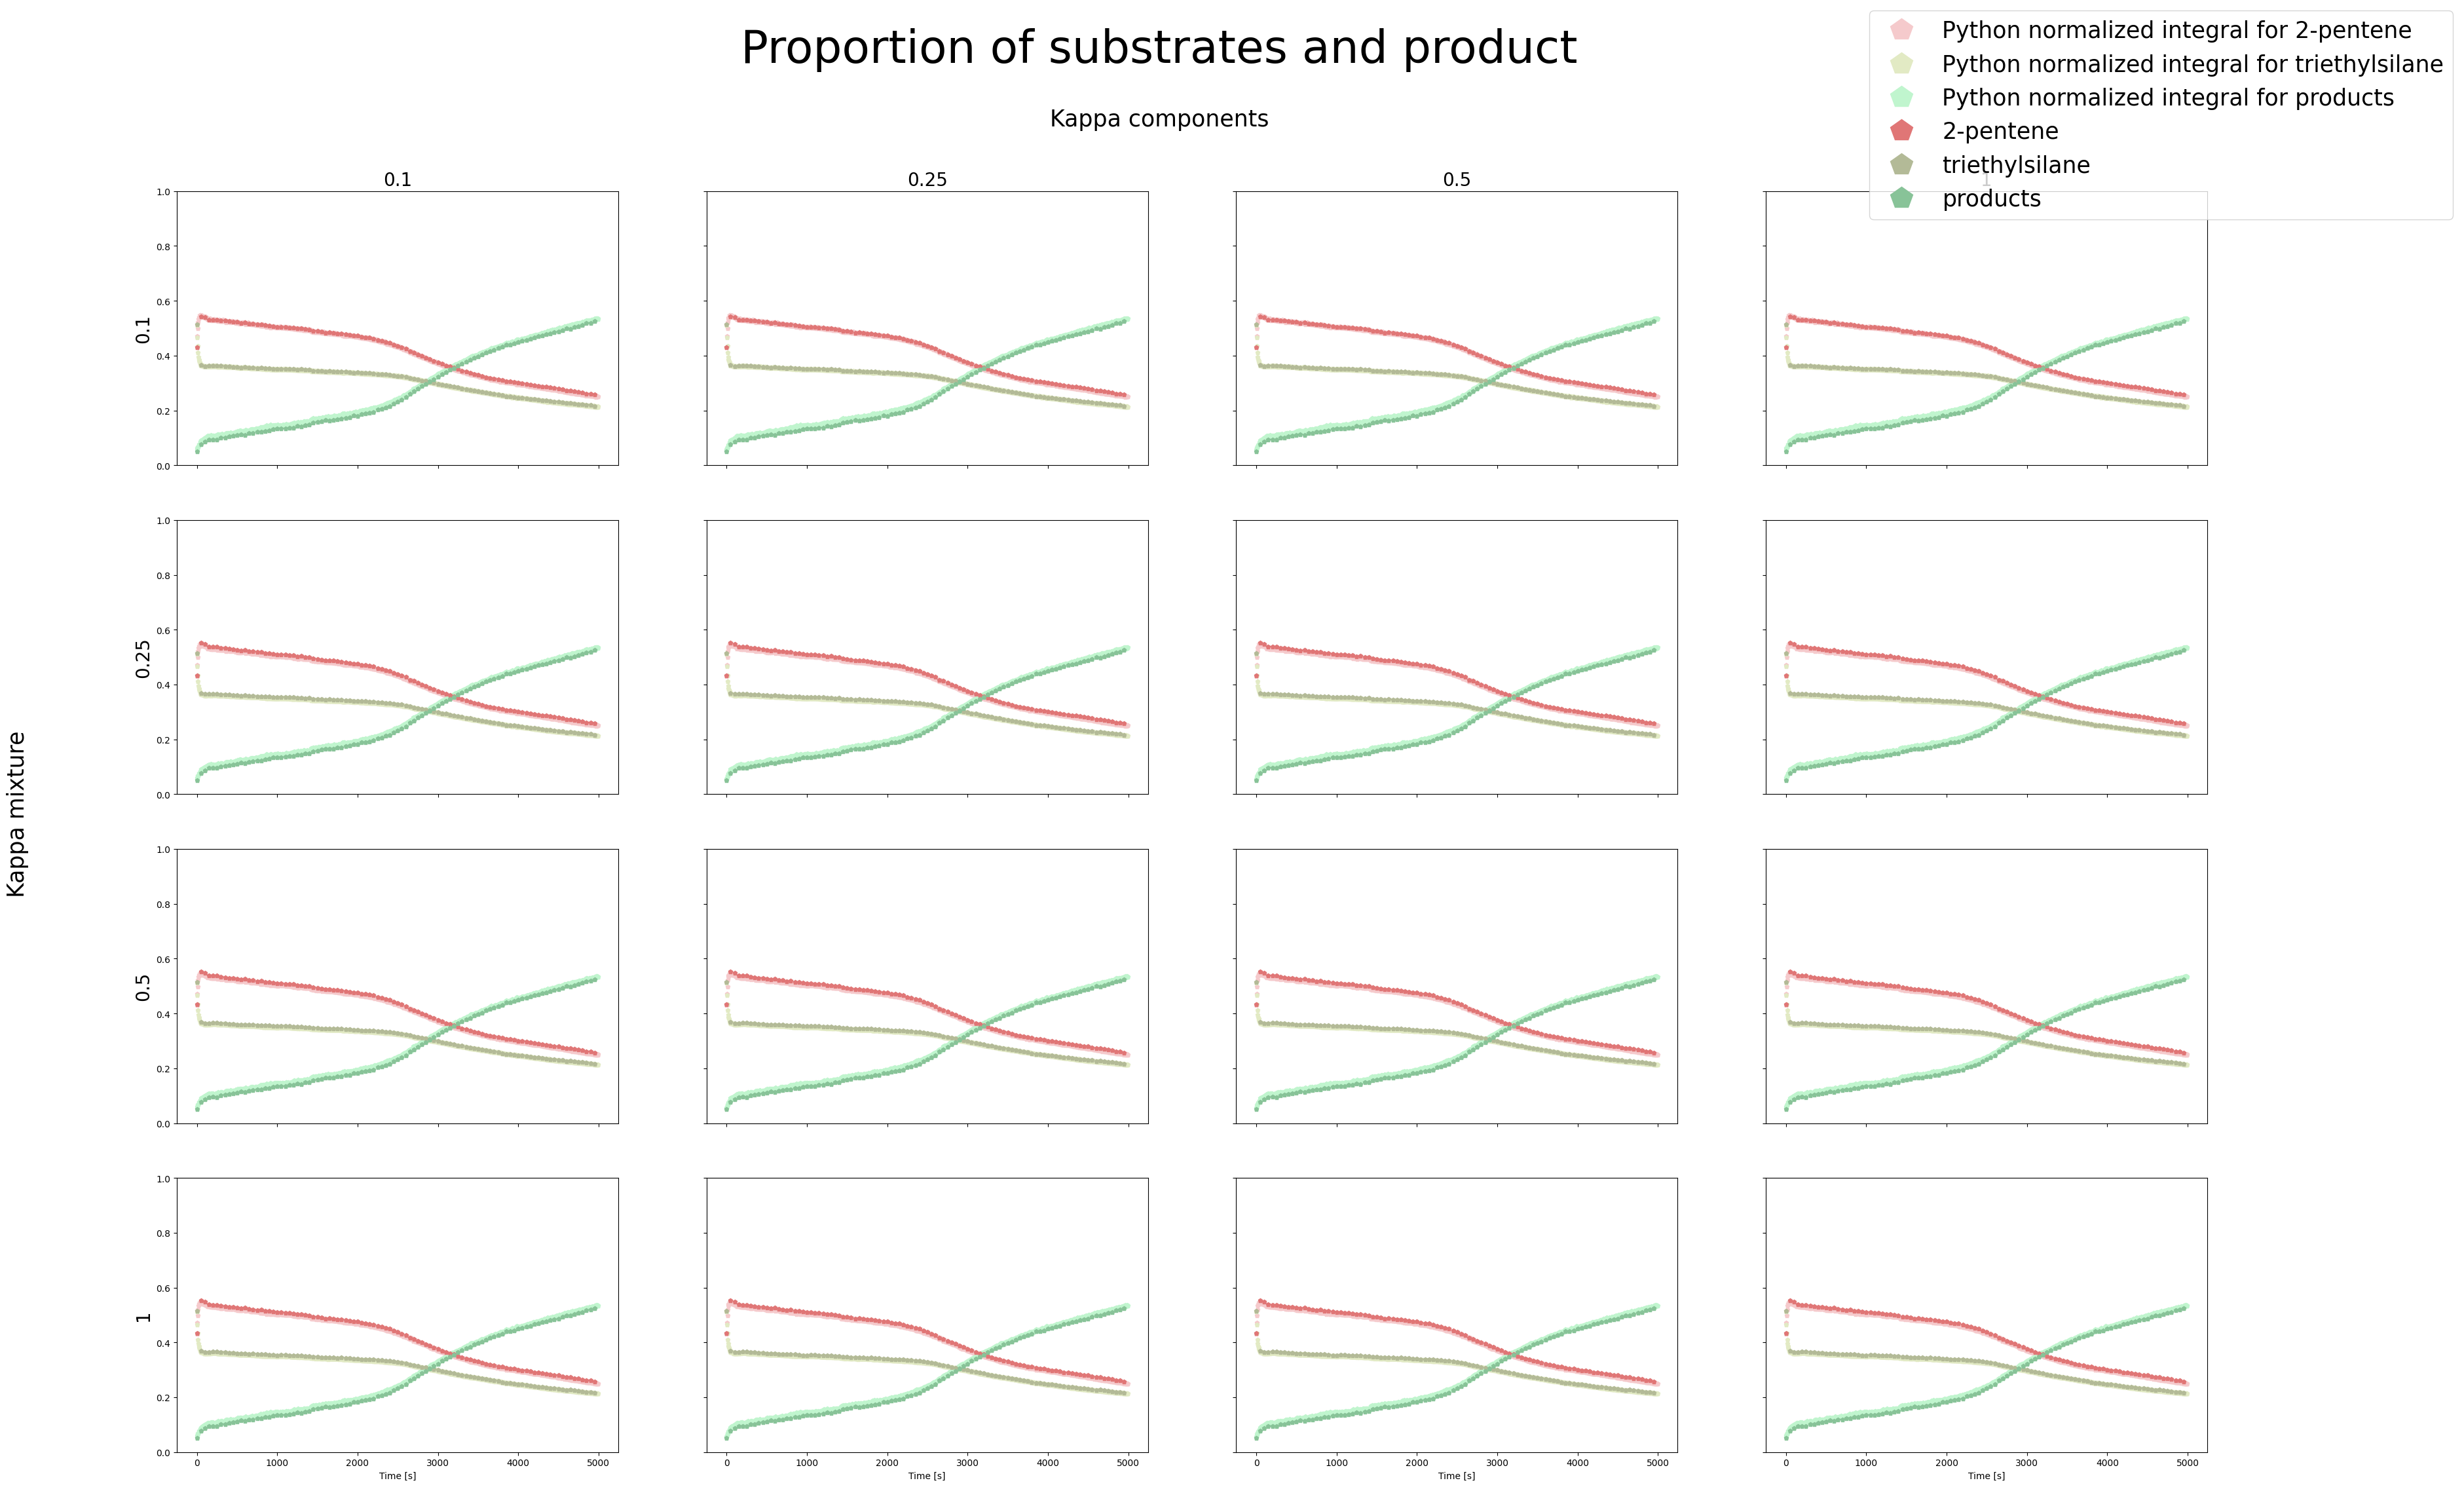

In [21]:
# colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
#              '#7f7f7f', '#bcbd22', '#17becf']

python_or_mnova = 'Python'
if python_or_mnova == 'Python':
    integrals_proportions = mnova_integrals_proportions
    time_range_integrals = time_range_integrals_mnova
elif python_or_mnova == 'Python':
    integrals_proportions = python_integrals_proportions
    time_range_integrals = time_range_integrals_python

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of substrates and product', fontsize=50)
fig.set_size_inches(40, 25, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        y = results_dict[(kappa, kappa_th)]
        for i in range(integrals_proportions.shape[1]):
            axx.plot(time_range_integrals[experiment_name], integrals_proportions[:,i], 'p', 
                     markersize=5, label=python_or_mnova + ' normalized integral for ' + substances_names[experiment_name][i],
                     color=colors_for_components[experiment_name][i]
                     #alpha=0.1
                    )
        for i in range(y.shape[1]):
            axx.plot(time_range[experiment_name], y[:,i], 'p', markersize=5, 
                     label=substances_names[experiment_name][i],
                    color=saturated_colors_for_components[experiment_name][i])

#         except AttributeError:
#             axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)
    
for ax, col in zip(axs[-1], cols):
    ax.set_xlabel('Time [s]', size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
handles, labels = ax.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='upper right', prop={'size': 25}, markerscale=5)

# for lh in legend.legendHandles[i+1:]: 
#     lh.set_alpha(0.5)

# plt.ylim(0,0.4)

# fig.savefig(results_paths[experiment_name] +
#                                         'comparison_for_different_kappas_components_separately_plus_integrals_' +
#                                         python_or_mnova +
#                                         '.png')

### Single plot magnetstein + integral (chosen values of parameters)

In [22]:
# saccharose: anything works, PMG 284: anything works, PMG 287: 0.1, 1
best_kappa = 0.1
best_kappa_th = 1

In [23]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

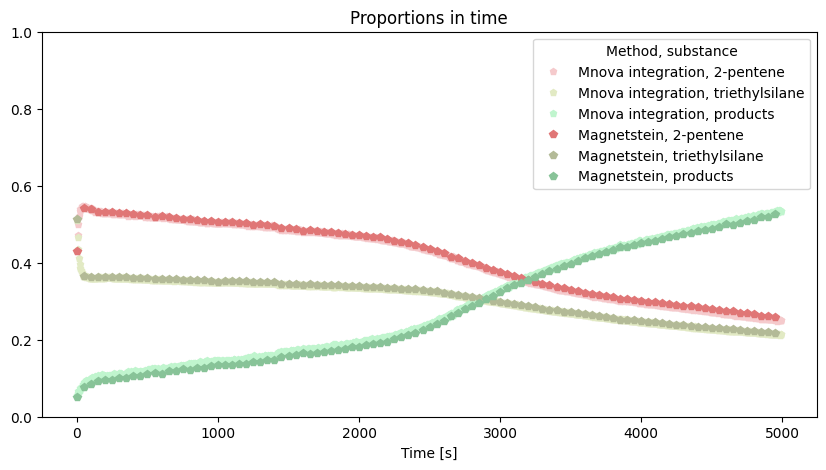

In [25]:
# colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
#              '#7f7f7f', '#bcbd22', '#17becf']

python_or_mnova = 'Mnova'
if python_or_mnova == 'Mnova':
    integrals_proportions = mnova_integrals_proportions
    time_range_integrals = time_range_integrals_mnova
elif python_or_mnova == 'Python':
    integrals_proportions = python_integrals_proportions
    time_range_integrals = time_range_integrals_python

include_integrals = True
if include_integrals:
    for i in range(integrals_proportions.shape[1]):
        plt.plot(time_range_integrals[experiment_name], integrals_proportions[:,i], 'p', 
                 markersize=5, label=python_or_mnova + ' integration, ' + substances_names[experiment_name][i],
                 color = colors_for_components[experiment_name][i]
                 #alpha=0.1
                )
for i in range(y.shape[1]):
    plt.plot(time_range[experiment_name], y[:, i], 'p', 
             label = 'Magnetstein, ' + substances_names[experiment_name][i],
            color=saturated_colors_for_components[experiment_name][i])

    plt.title('Proportions in time')
plt.xlabel('Time [s]')
plt.ylim(0,1)
#plt.ylim(0, 0.4)
    
leg = plt.legend(title='Method, substance')    
plt.gcf().set_size_inches(10, 5)

# for lh in leg.legendHandles[:y.shape[1]]: 
#     lh.set_alpha(0.4)

# plt.savefig(results_paths[experiment_name]+'all_components_on_one_plot_plus_integrals_'+
#                                                     python_or_mnova +
#                                                     '_kappa_' +
#                                                 str(best_kappa)+'_kappa_th_' + 
#                                                 str(best_kappa_th) +'.png', dpi=300)

### Single plot magnetstein + MNova + Python (chosen values of parameters)

In [26]:
# saccharose: anything works, PMG 284: anything works, PMG 287: 0.1, 1
best_kappa = 0.1
best_kappa_th = 1

In [27]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [28]:
#%matplotlib notebook

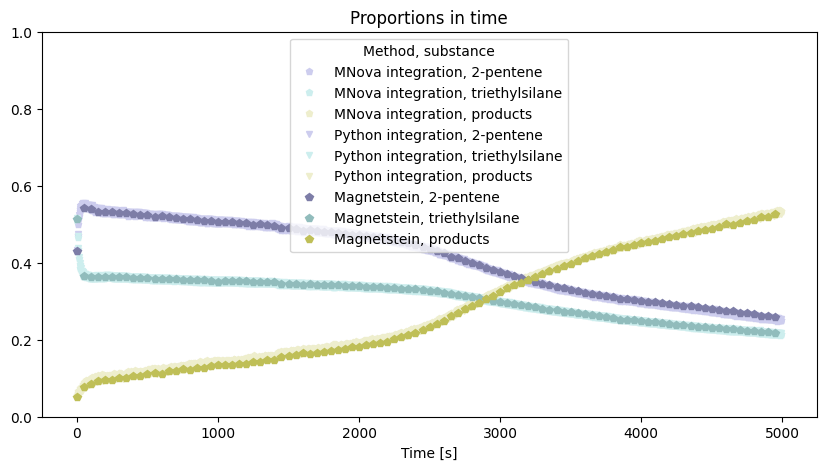

In [29]:
include_integrals = True
if include_integrals:
    for i in range(mnova_integrals_proportions.shape[1]):
        plt.plot(time_range_integrals_mnova[experiment_name], mnova_integrals_proportions[:,i], 'p', 
                 markersize=5, label='MNova integration, ' + substances_names[experiment_name][i],
                 color = colors_for_components[experiment_name][i]
                 #alpha=0.1
                )
    for i in range(python_integrals_proportions.shape[1]):
        plt.plot(time_range_integrals_python[experiment_name], python_integrals_proportions[:,i], 'v', 
                 markersize=5, label='Python integration, ' + substances_names[experiment_name][i],
                 color = colors_for_components[experiment_name][i]
                 #alpha=0.1
                )
for i in range(y.shape[1]):
    plt.plot(time_range[experiment_name], y[:, i], 'p', 
             label = 'Magnetstein, ' + substances_names[experiment_name][i],
            color=saturated_colors_for_components[experiment_name][i])

    plt.title('Proportions in time')
plt.xlabel('Time [s]')
plt.ylim(0,1)
#plt.ylim(0, 0.4)

    
leg = plt.legend(title='Method, substance')    
# for lh in leg.legendHandles[:y.shape[1]]: 
#     lh.set_alpha(0.4)
plt.gcf().set_size_inches(10, 5)
# plt.savefig(results_paths[experiment_name]+'all_components_on_one_plot_plus_integrals_MNova_Python'+
#                                                     '_kappa_' +
#                                                 str(best_kappa)+'_kappa_th_' + 
#                                                 str(best_kappa_th) +'.png')

### Integral only

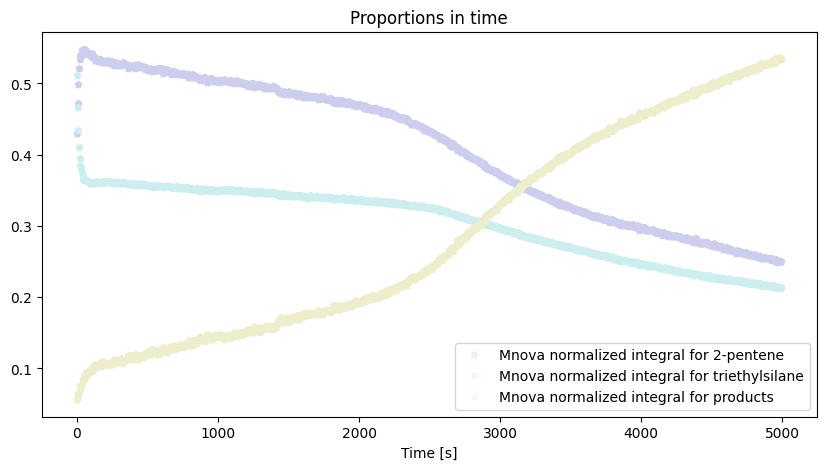

In [30]:
# colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
#              '#7f7f7f', '#bcbd22', '#17becf']

python_or_mnova = 'Mnova'
if python_or_mnova == 'Mnova':
    integrals_proportions = mnova_integrals_proportions
    time_range_integrals = time_range_integrals_mnova
elif python_or_mnova == 'Python':
    integrals_proportions = python_integrals_proportions
    time_range_integrals = time_range_integrals_python

    
for i in range(integrals_proportions.shape[1]):
    plt.plot(time_range_integrals[experiment_name], integrals_proportions[:,i], 'p', 
             markersize=5, label=python_or_mnova + ' normalized integral for ' + substances_names[experiment_name][i],
             color = colors_for_components[experiment_name][i]#, alpha=0.03
            )

plt.title('Proportions in time')
plt.xlabel('Time [s]')
#plt.ylim(0,1)
    
leg = plt.legend()    
for lh in leg.legendHandles[:4]: 
    lh.set_alpha(0.25)
plt.gcf().set_size_inches(10, 5)
# plt.savefig(results_paths[experiment_name]+'all_components_integrals_on_one_plot_plus_integrals_' +
#                                                     python_or_mnova +
#                                                     '_kappa' +
#                                                 str(best_kappa)+'_kappa_th_' + 
#                                                 str(best_kappa_th) +'.png')

### Visualising results for different parameters, all components added + integrals

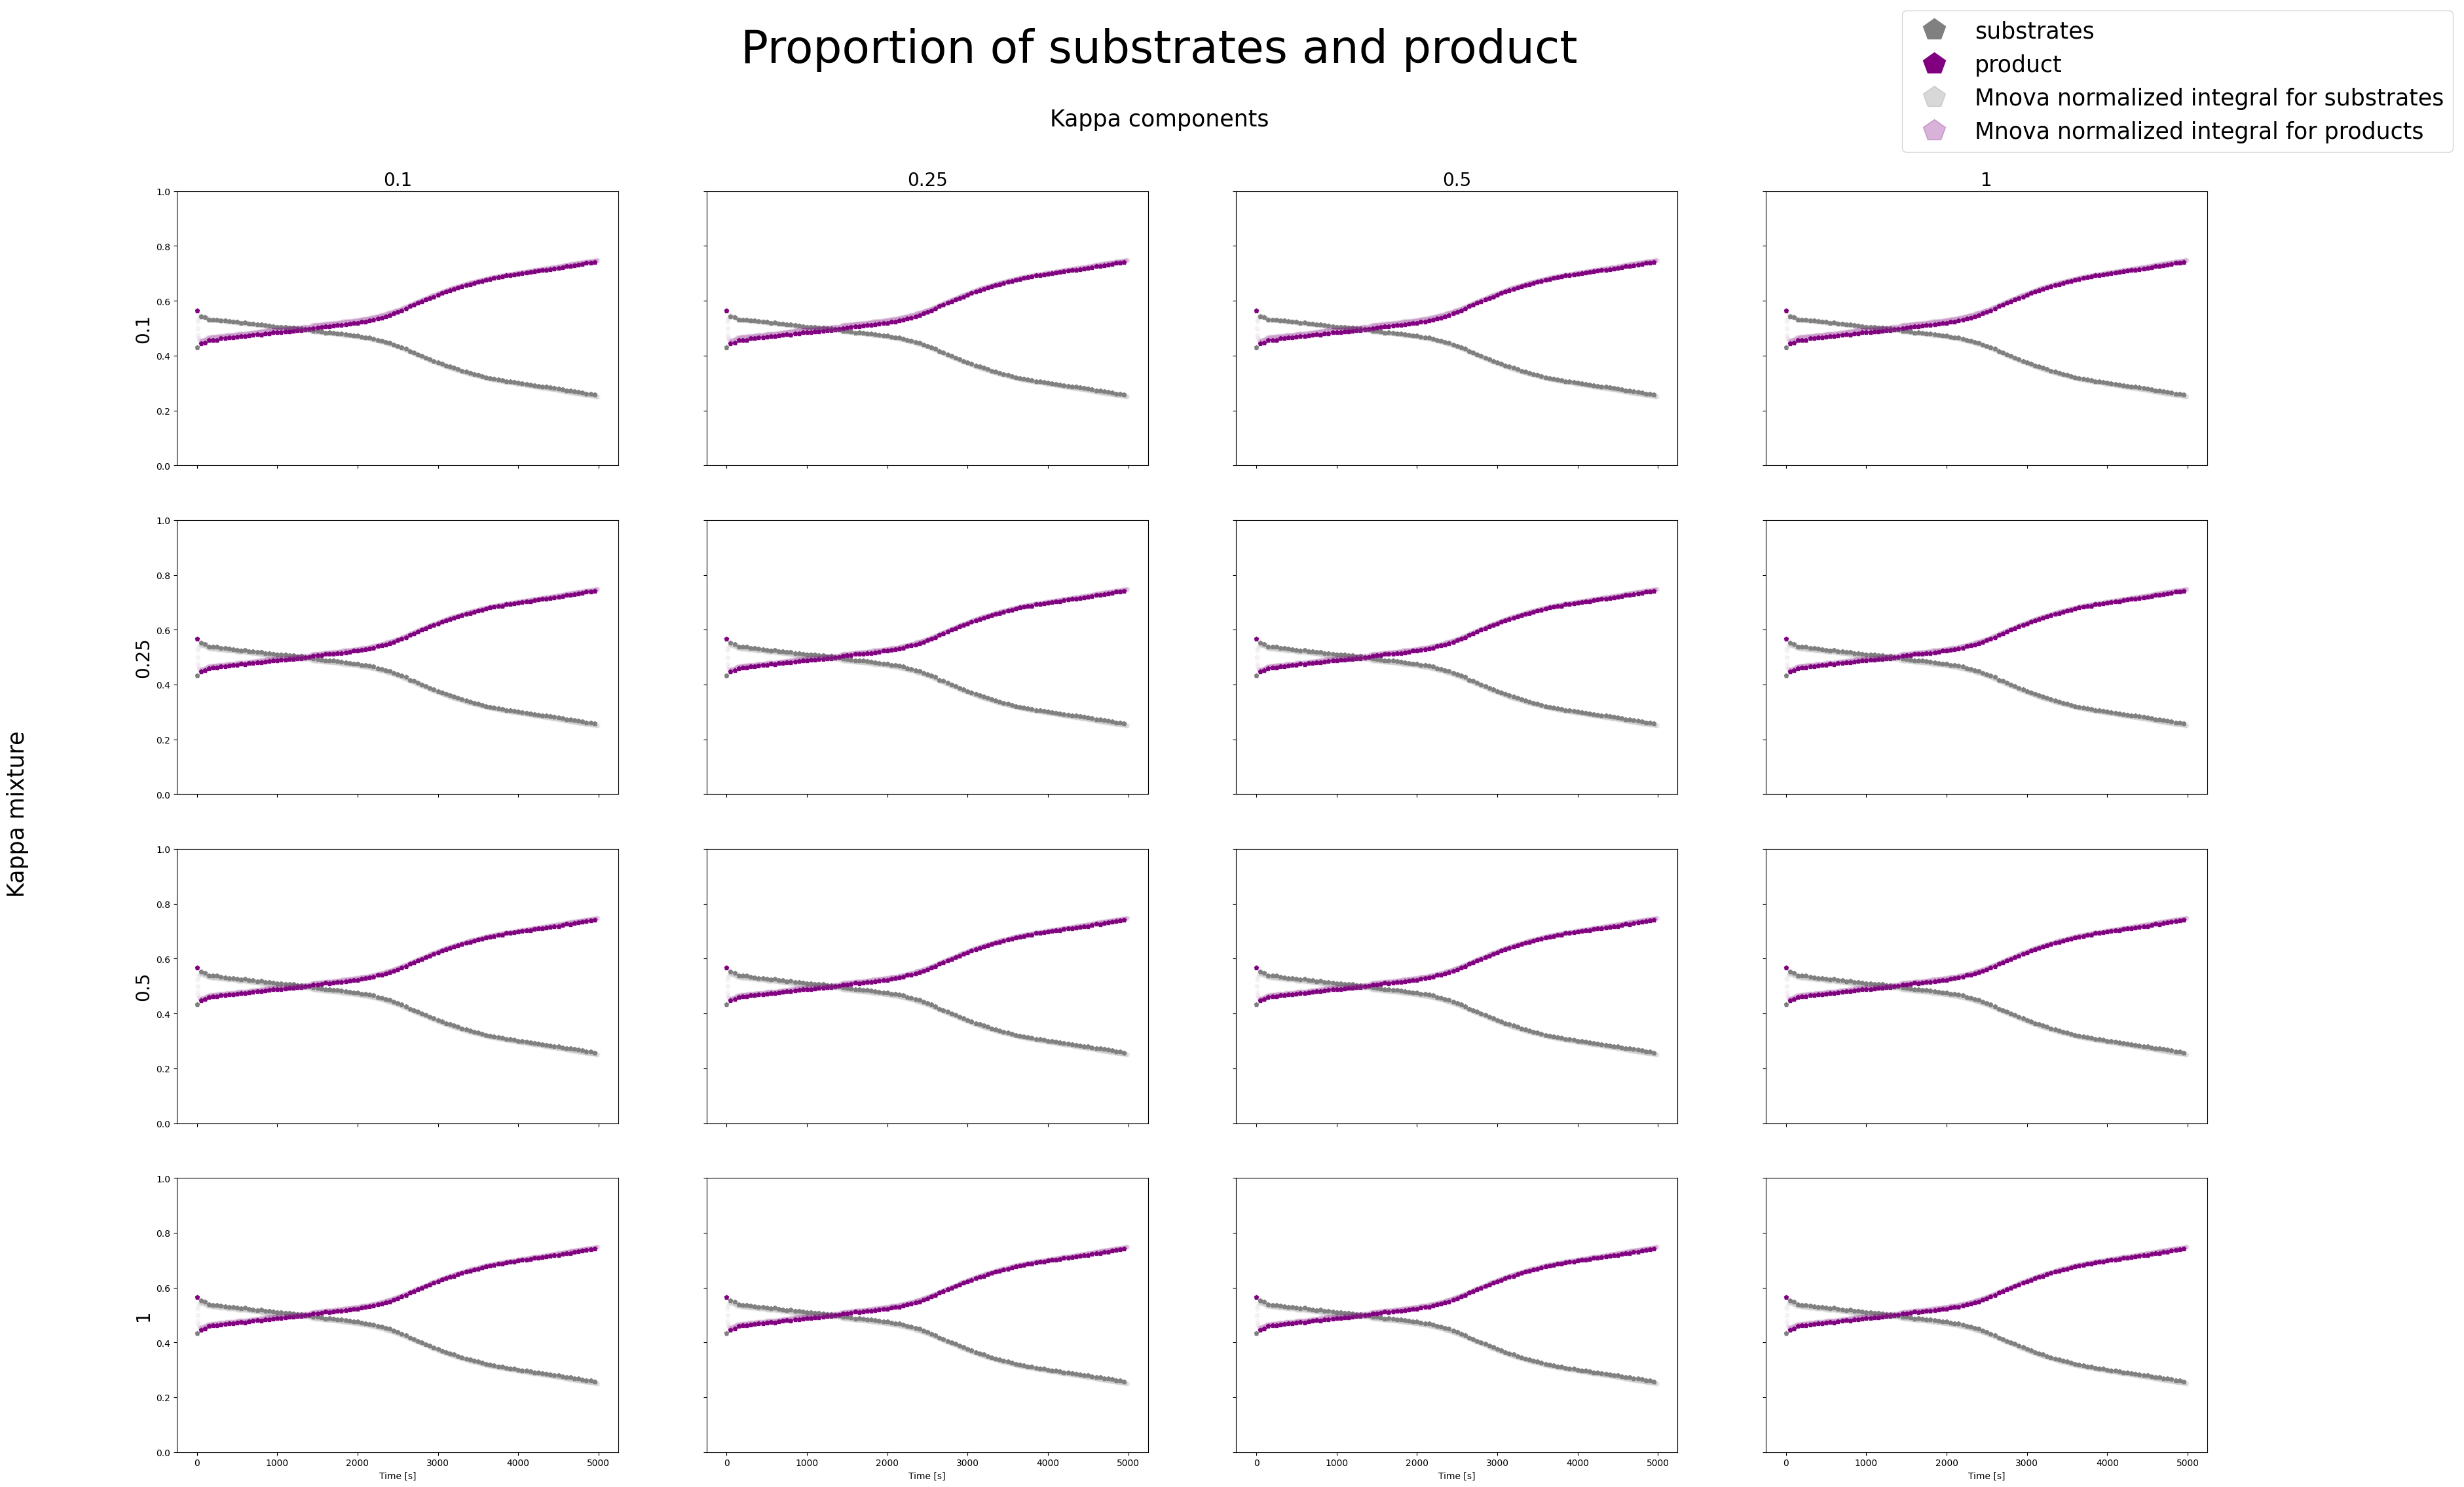

In [31]:
components_numbers = [0]
product_numbers = [1,2]

python_or_mnova = 'Mnova'
if python_or_mnova == 'Mnova':
    integrals_proportions = mnova_integrals_proportions
    time_range_integrals = time_range_integrals_mnova
elif python_or_mnova == 'Python':
    integrals_proportions = python_integrals_proportions
    time_range_integrals = time_range_integrals_python

colors_list = ['grey', 'purple']

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of substrates and product', fontsize=50)
fig.set_size_inches(40, 25, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]

        #components
        y = 0
        for nr in components_numbers:
            y = y + results_dict[(kappa, kappa_th)][:, nr]
        axx.plot(time_range[experiment_name], y, 'p', markersize=5,
                label='substrates',
                    color = colors_list[0])
        #product
        y = 0
        for nr in product_numbers:
            y = y + results_dict[(kappa, kappa_th)][:, nr]
        axx.plot(time_range[experiment_name], y, 'p', markersize=5,
                label='product',
                    color = colors_list[1])
        y = results_dict[(kappa, kappa_th)]
        axx.plot(time_range_integrals[experiment_name], integrals_proportions[:,components_numbers].sum(axis=1), 'p', 
                     markersize=5, label=python_or_mnova + ' normalized integral for substrates',
                     color = colors_list[0], alpha=0.03
                    )
        axx.plot(time_range_integrals[experiment_name], integrals_proportions[:,product_numbers].sum(axis=1), 'p', 
                     markersize=5, label=python_or_mnova + ' normalized integral for products',
                     color = colors_list[1], alpha=0.03
                    )
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)
    
for ax, col in zip(axs[-1], cols):
    ax.set_xlabel('Time [s]', size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
handles, labels = ax.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='upper right', prop={'size': 25}, markerscale=5)

for lh in legend.legendHandles[2:]: 
    lh.set_alpha(0.3)
#fig.savefig(results_paths[experiment_name]+
#                 'comparison_for_different_kappas_components_together_plus_integrals_' +
#                 python_or_mnova + 
#                 '.png')

### Components together

In [32]:
components_numbers = [0,1]
lin_regr = False

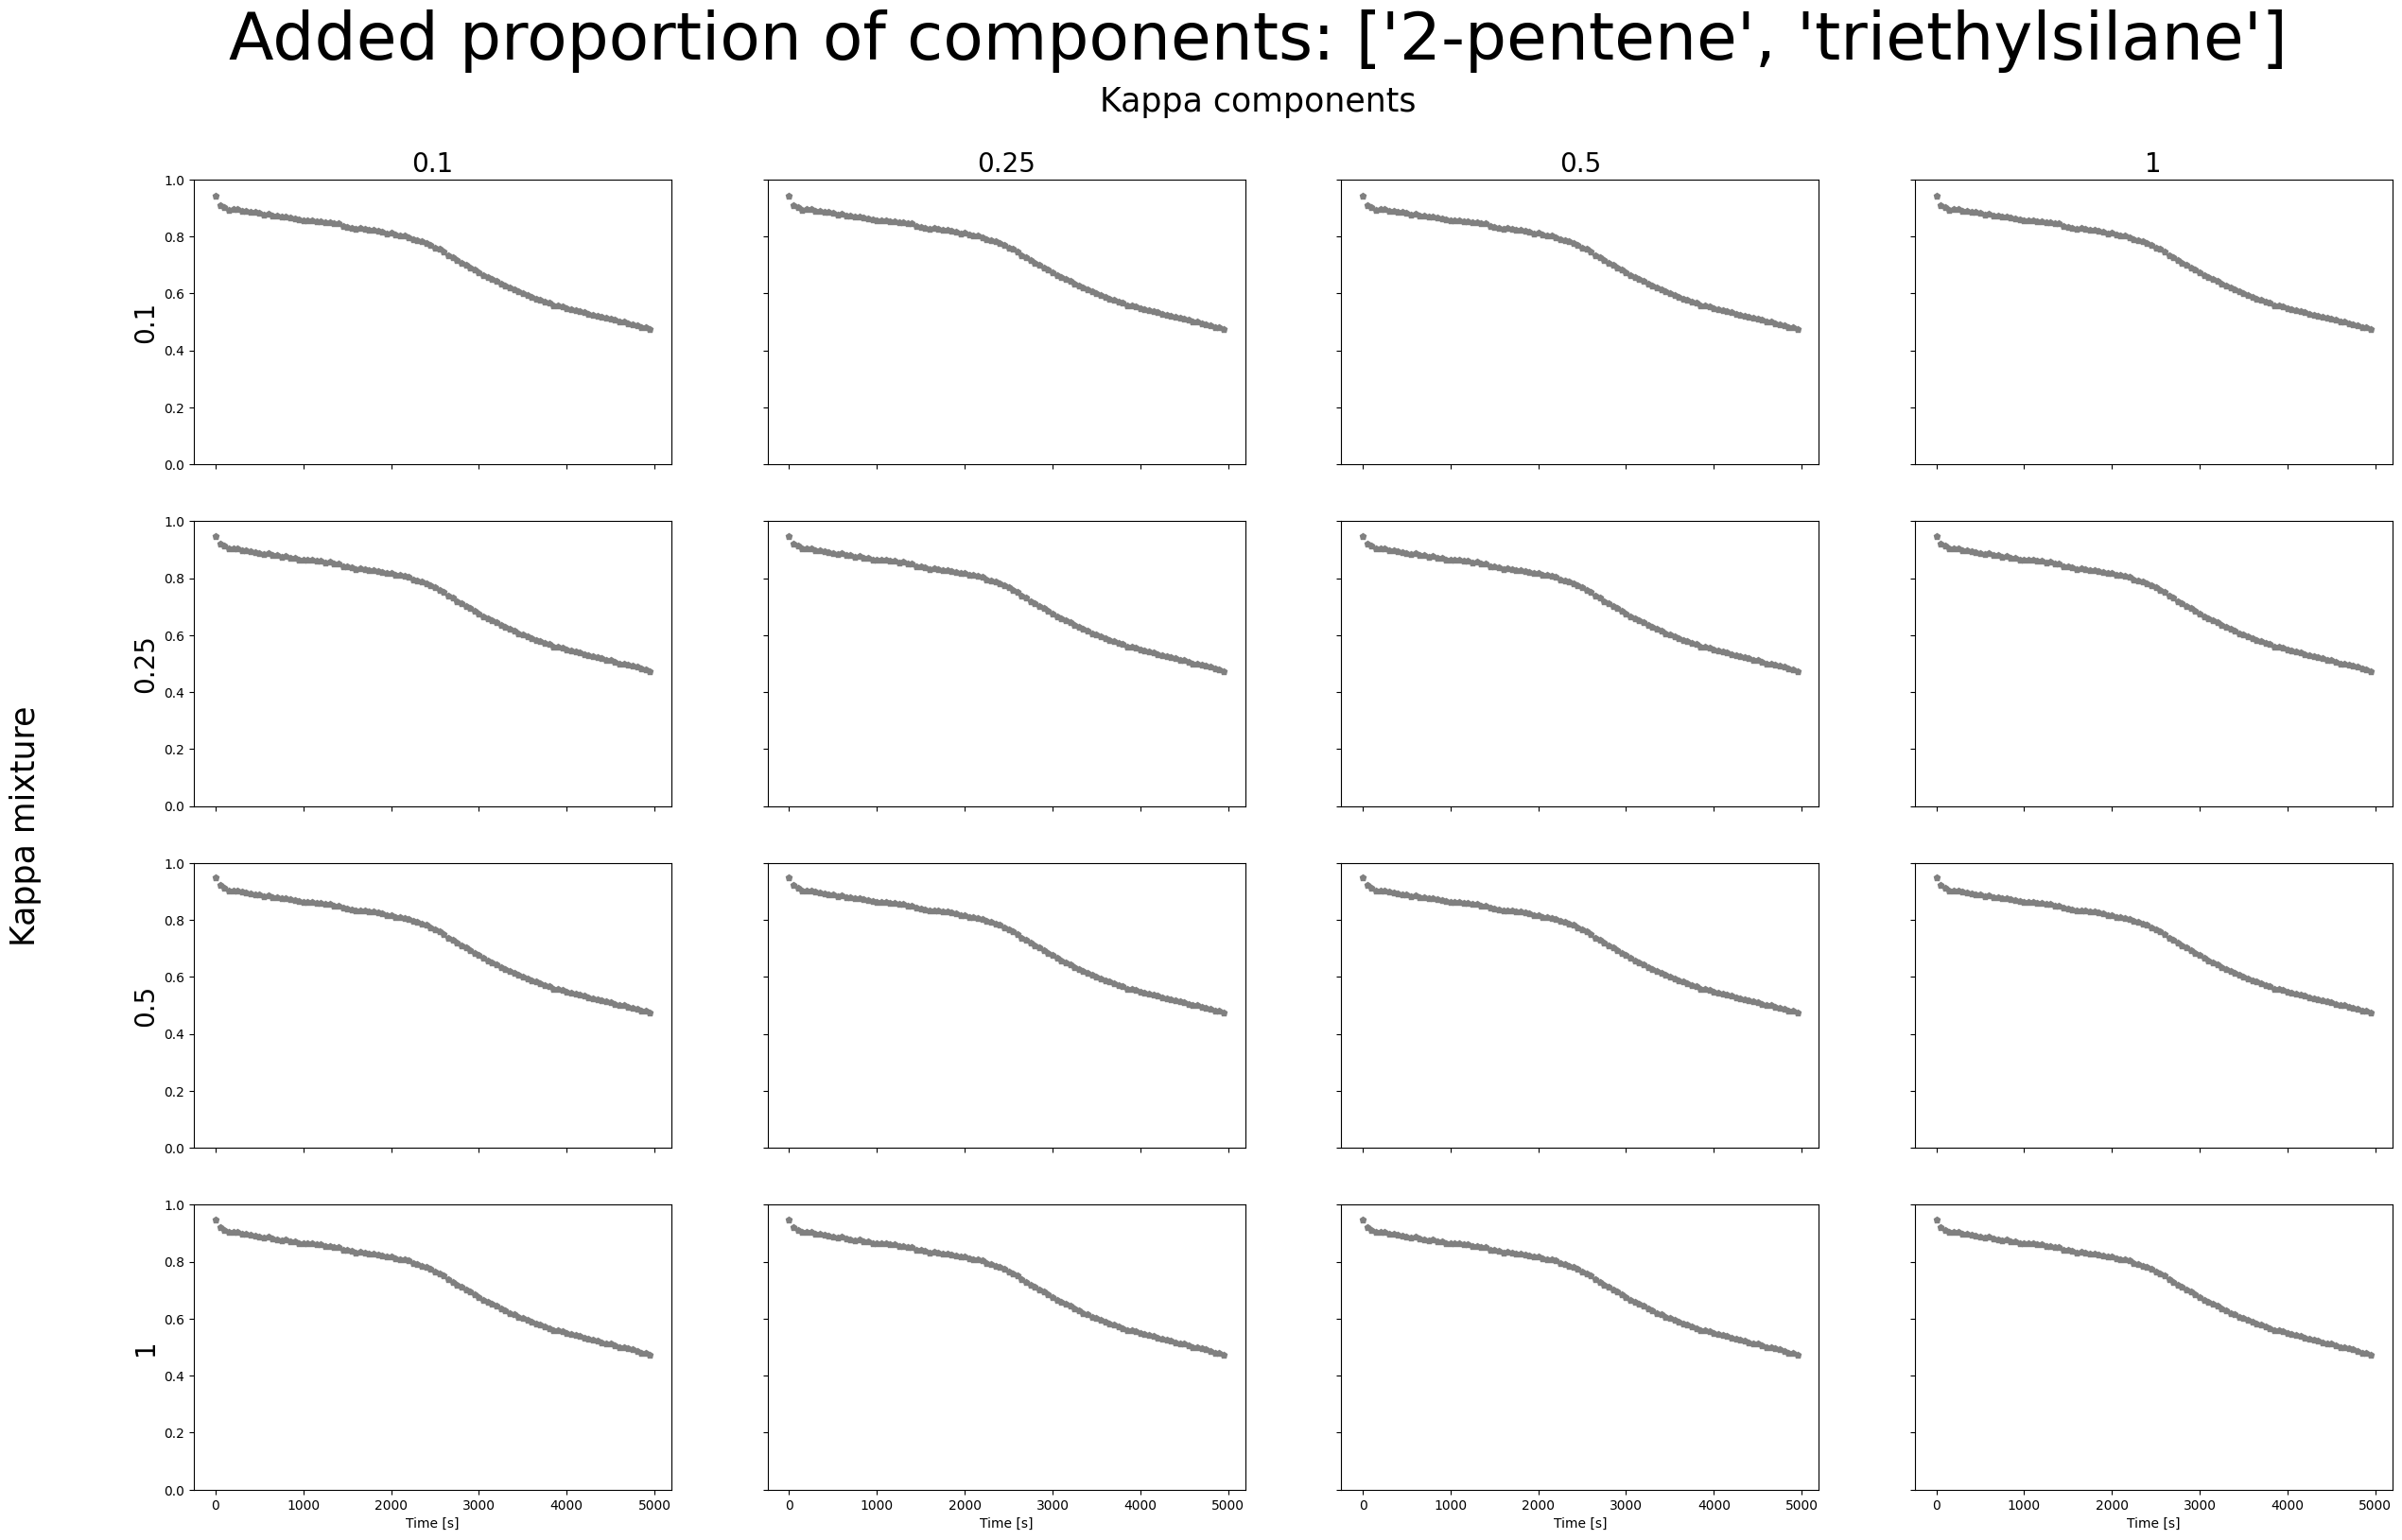

In [33]:
names = [substances_names[experiment_name][nr] for nr in components_numbers]

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Added proportion of components: ' + str(names), fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = 0
            for nr in components_numbers:
                y = y + results_dict[(kappa, kappa_th)][:, nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5,
                    color='grey')

            if lin_regr:
                t = np.array(time_range[experiment_name])
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(time_range[experiment_name], slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)
    
for ax, col in zip(axs[-1], cols):
    ax.set_xlabel('Time [s]', size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_sum_of_components_' +
#                                                   str(names) +'.png')

### Single plot for chosen values of parameters

#### Components separately

In [34]:
best_kappa = 0.1
best_kappa_th = 1

In [35]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [38]:
component_nr = 2
lin_regr = False

Text(0.5, 0, 'Time [s]')

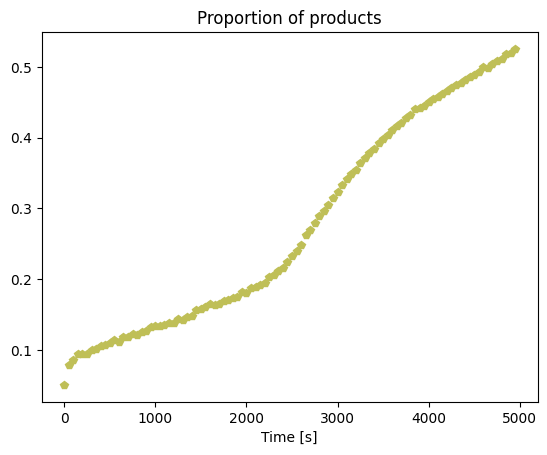

In [39]:
plt.plot(time_range[experiment_name], y[:, component_nr], 'p',
        color = saturated_colors_for_components[experiment_name][component_nr])
if lin_regr:
    t = np.array(time_range[experiment_name])
    t_and_ones = np.vstack([t, np.ones(len(t))]).T
    slope, intercept = np.linalg.lstsq(t_and_ones, y[:, component_nr])[0]
    plt.plot(time_range[experiment_name], slope*t+intercept)
#plt.title('Proportion of '+substances_names[experiment_name][component_nr])
plt.title('Proportion of ' + substances_names[experiment_name][component_nr])
plt.xlabel('Time [s]')

#### Components added together

In [40]:
best_kappa = 0.1
best_kappa_th = 1

In [41]:
component_numbers = [0, 1]
lin_regr = False

In [42]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 0, 'Time [s]')

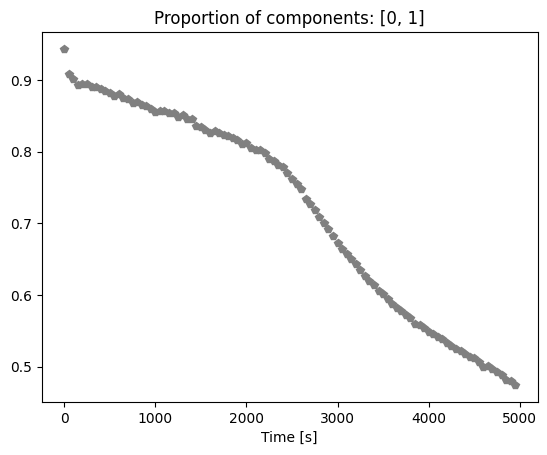

In [43]:
plt.plot(time_range[experiment_name], y[:,component_numbers].sum(1), 'p',
        color='grey')
if lin_regr:
    t = np.array(time_range[experiment_name])
    t_and_ones = np.vstack([t, np.ones(len(t))]).T
    slope, intercept = np.linalg.lstsq(t_and_ones, y[:, component_nr])[0]
    plt.plot(time_range[experiment_name], slope*t+intercept)
plt.title('Proportion of components: ' + str(component_numbers))
plt.xlabel('Time [s]')
#plt.ylim(0.5,1)

#### Noise proportion

In [44]:
best_kappa = 0.1
best_kappa_th = 1

In [45]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 0, 'Time [s]')

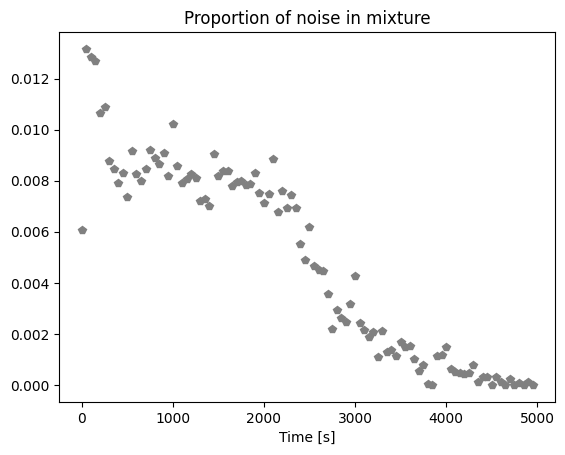

In [46]:
plt.plot(time_range[experiment_name], 1-y.sum(axis=1), 'p',
        color='grey')
plt.title('Proportion of noise in mixture')
plt.xlabel('Time [s]')

Another way:

In [47]:
with open(results_paths[experiment_name]+'noise_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = [sum(l) for l in y]

Text(0.5, 0, 'Time [s]')

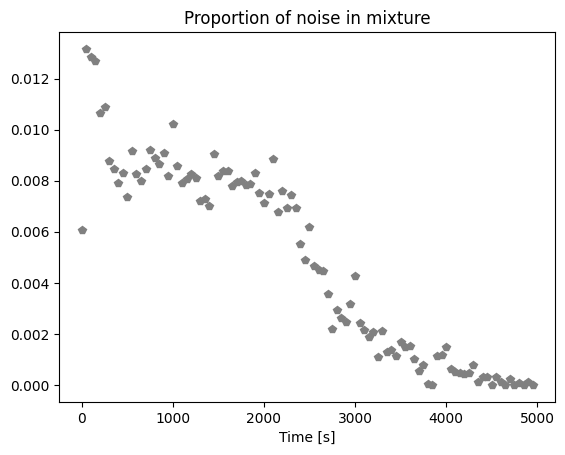

In [48]:
plt.plot(time_range[experiment_name], y, 'p',
        color='grey')
plt.title('Proportion of noise in mixture')
plt.xlabel('Time [s]')

#### Product and substrates together

In [49]:
best_kappa = 0.1
best_kappa_th = 1

In [50]:
component_numbers = [0, 1]
product_numbers = [2]
lin_regr = False

In [51]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 0, 'Time [s]')

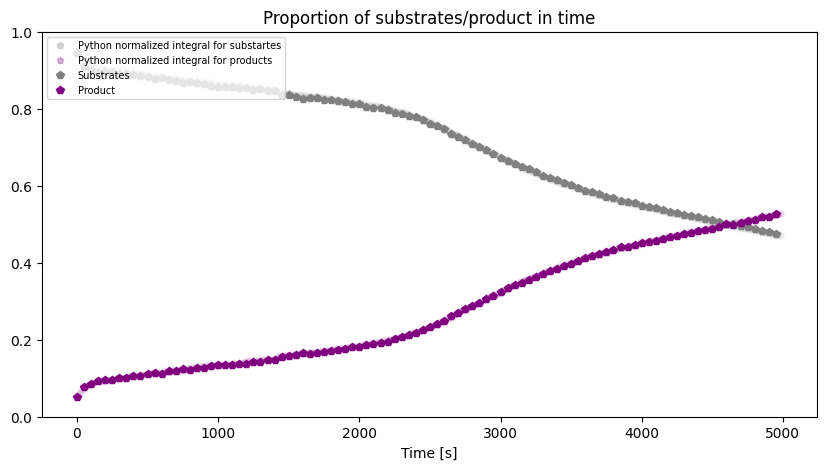

In [52]:
#Version when we don't have spectrum of product (i.e. we assume that noise in mixture is product)

colors_list = ['grey', 'purple']

python_or_mnova = 'Python'
if python_or_mnova == 'Mnova':
    integrals_proportions = mnova_integrals_proportions
    time_range_integrals = time_range_integrals_mnova
elif python_or_mnova == 'Python':
    integrals_proportions = python_integrals_proportions
    time_range_integrals = time_range_integrals_python

include_integrals = True
if include_integrals:
    plt.plot(time_range_integrals[experiment_name], integrals_proportions[:,component_numbers].sum(axis=1), 'p', 
                 markersize=5, label=python_or_mnova + ' normalized integral for substartes',
                 color = colors_list[0], alpha=0.03
                )
    plt.plot(time_range_integrals[experiment_name], integrals_proportions[:,product_numbers].sum(axis=1), 'p', 
                 markersize=5, label=python_or_mnova + ' normalized integral for products',
                 color = colors_list[1], alpha=0.03
                )

plt.plot(time_range[experiment_name], y[:,component_numbers].sum(1), 'p', label='Substrates', color = colors_list[0])
plt.plot(time_range[experiment_name], y[:,product_numbers].sum(1), 'p', label='Product', color = colors_list[1])

plt.ylim(0,1)
#plt.plot(list(range(y.shape[0]*10))[::10], 1-y.sum(axis=1), 'p', label='Product')

#leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
leg = plt.legend(loc='upper left', prop = {"size": 7})    

for lh in leg.legendHandles[:2]: 
    lh.set_alpha(0.3)
plt.gcf().set_size_inches(10, 5)

plt.title('Proportion of substrates/product in time')
plt.xlabel('Time [s]')
#plt.savefig(results_paths[experiment_name]+
#                             'substrates_and_product_together_plus_integrals_' + 
#                             python_or_mnova + 
#                             '_kappa_' + 
#                             str(best_kappa) +
#                             '_kappa_th_' +
#                             str(best_kappa_th)
#                             +'.png')

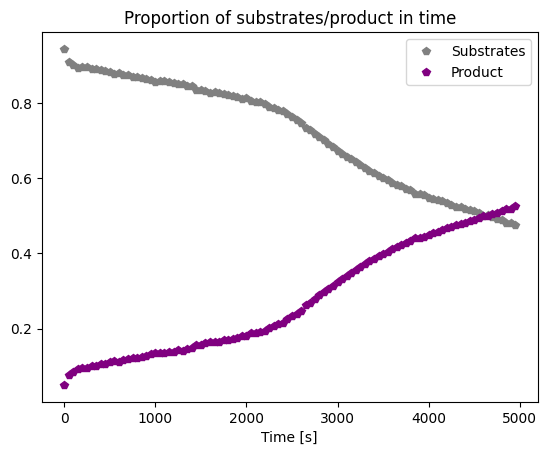

In [53]:
#Version when we have spectrum of product

colors_list = ['grey', 'purple']

#Below: version with rescaled time (every 10th measurement was checked)
plt.plot(time_range[experiment_name], y[:,component_numbers].sum(1), 'p', label='Substrates',
        color=colors_list[0])
#plt.ylim(0.5,1)
plt.plot(time_range[experiment_name], y[:,product_numbers].sum(1), 'p', label='Product',
        color=colors_list[1])
plt.title('Proportion of substrates/product in time')
plt.xlabel('Time [s]')
plt.legend()
# plt.savefig(results_paths[experiment_name]+'substrates_and_product_together_' + str(best_kappa) +'_'+str(best_kappa_th)+'.png')

### Noise in components

In [54]:
best_kappa = 0.1
best_kappa_th = 1

In [55]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 0, 'Time [s]')

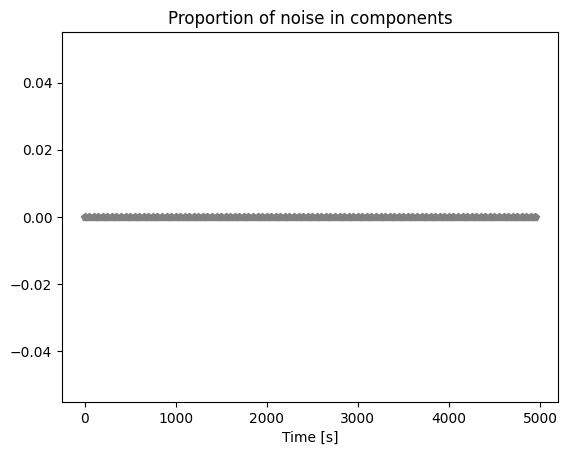

In [56]:
plt.plot(time_range[experiment_name], y, 'p', 
        color='grey')
plt.title('Proportion of noise in components')
plt.xlabel('Time [s]')

### Noise proportion

In [57]:
components_numbers = list(range(len(substances_names[experiment_name])))
lin_regr = False

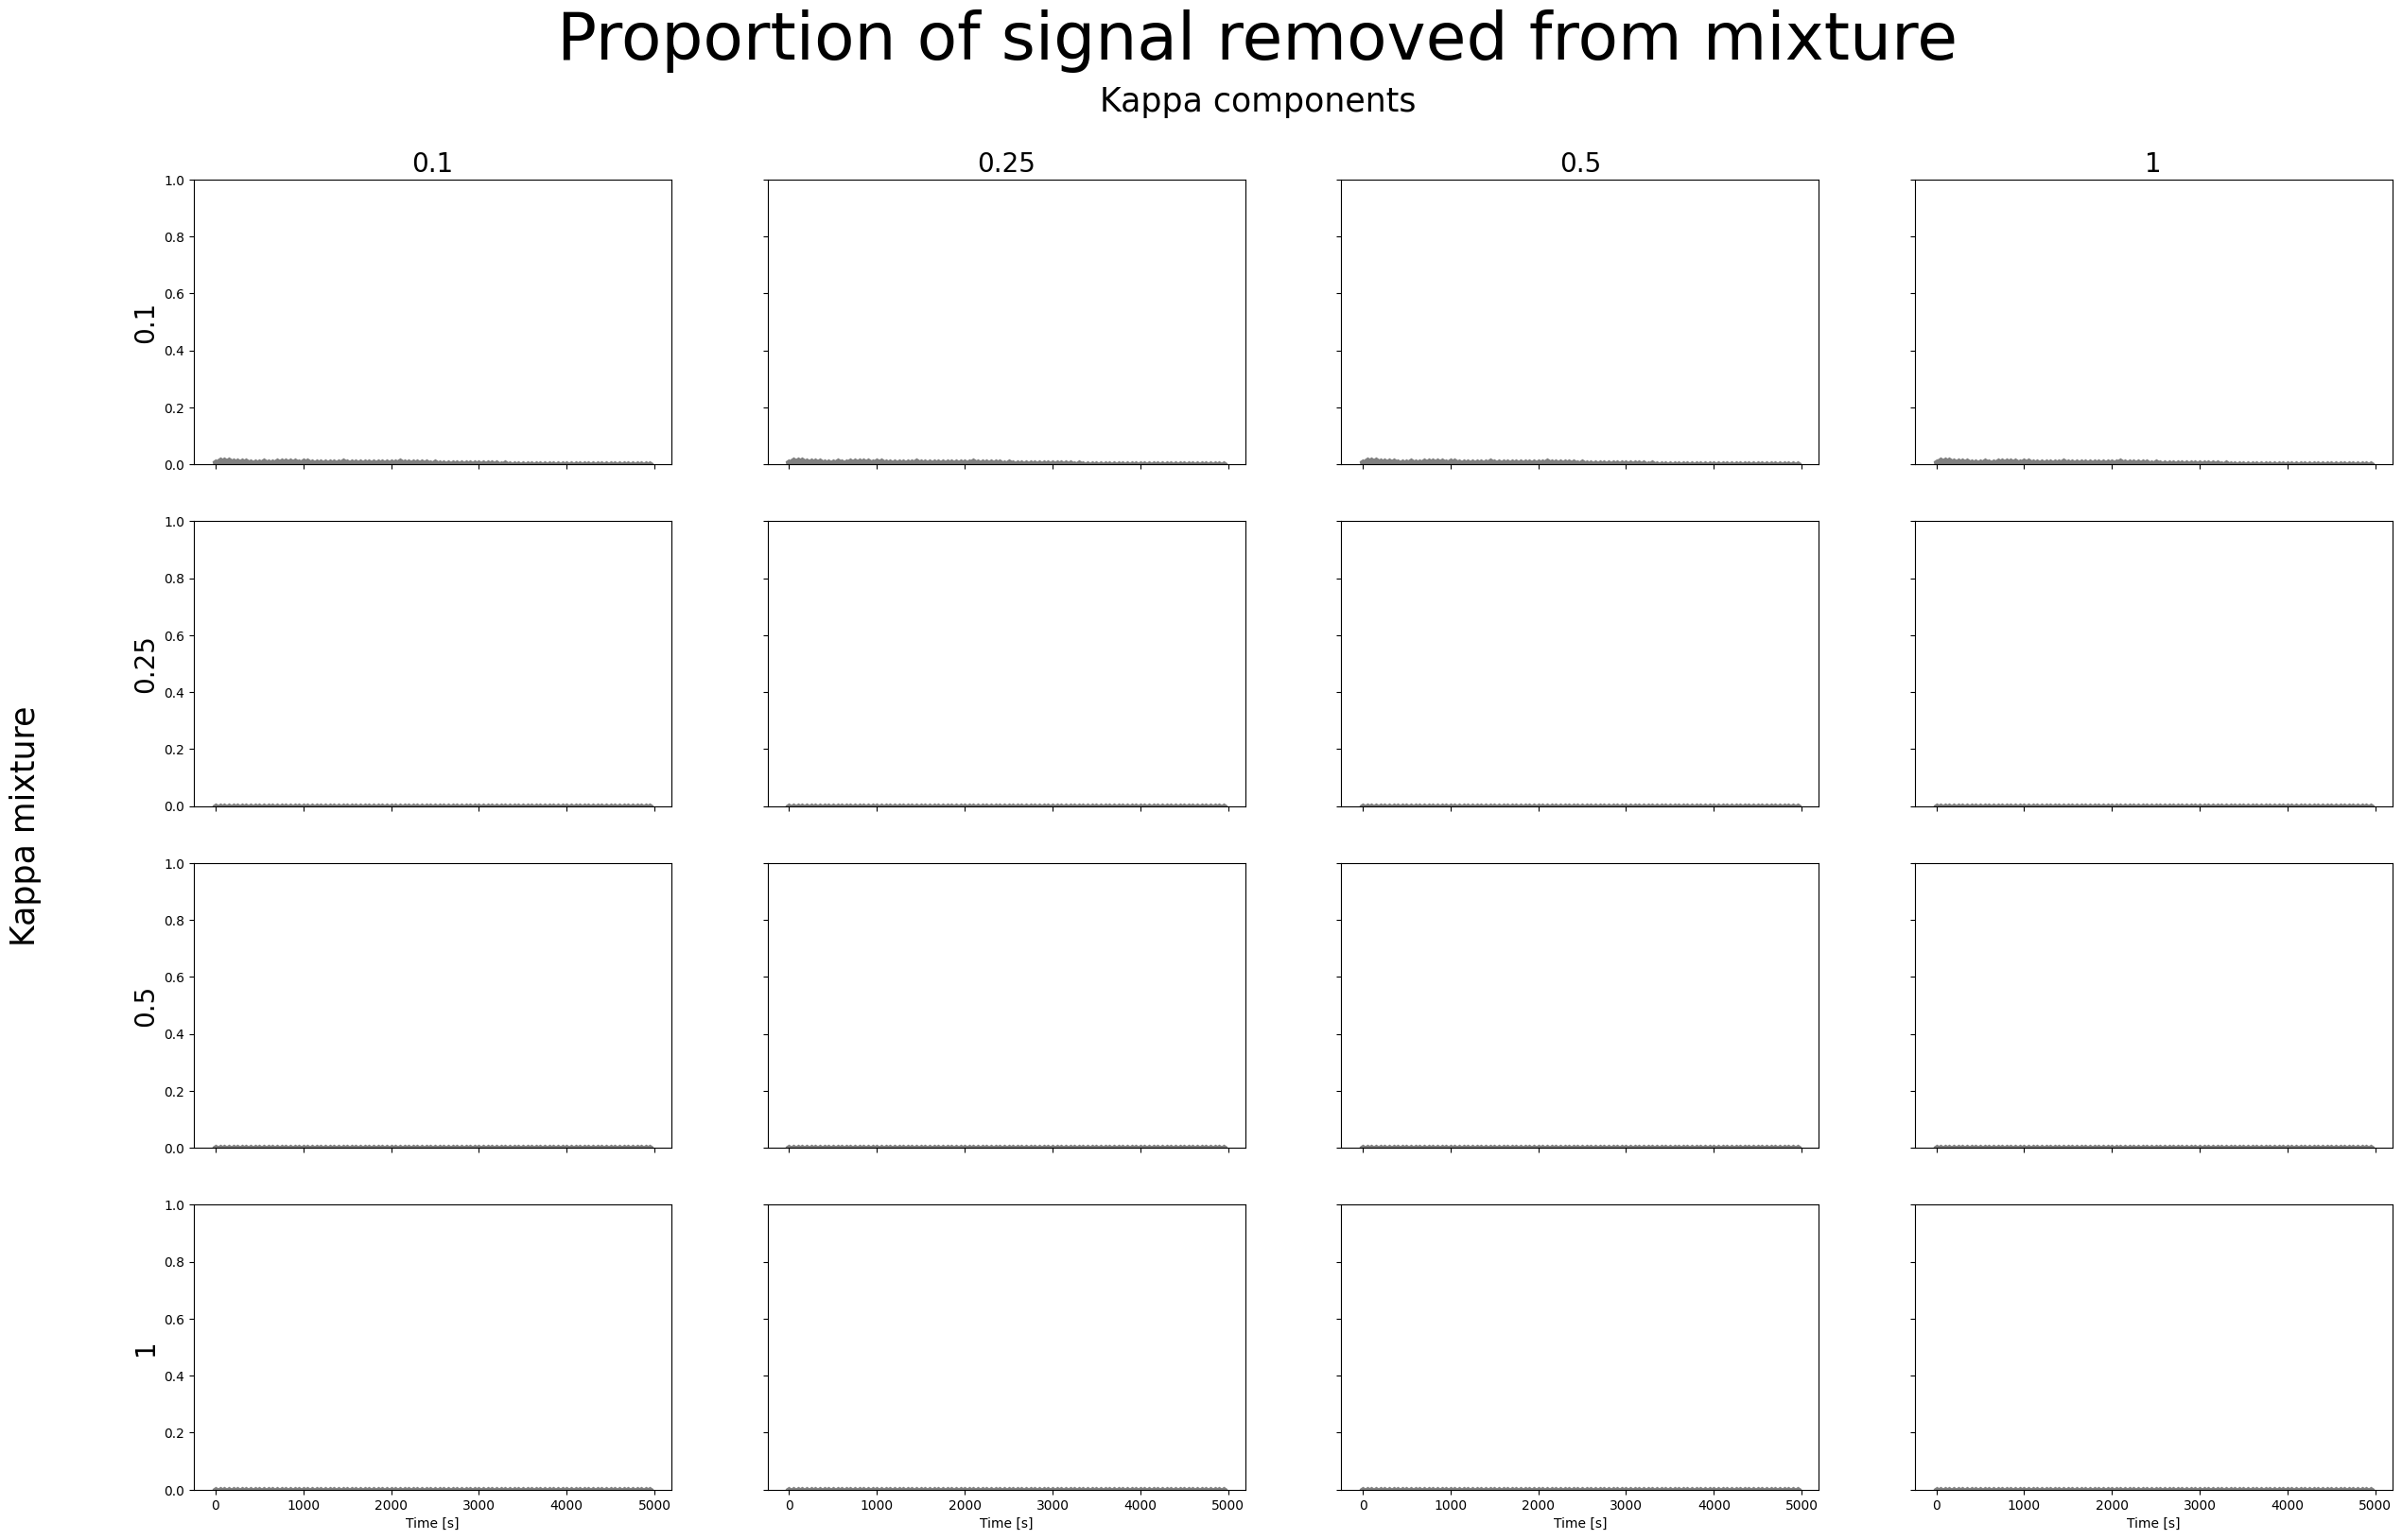

In [58]:
names = [substances_names[experiment_name][nr] for nr in components_numbers]

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of signal removed from mixture', fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = 1
            for nr in components_numbers:
                y = y - results_dict[(kappa, kappa_th)][:, nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5,
                    color='grey')
            if lin_regr:
                t = np.array(time_range[experiment_name])
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(time_range[experiment_name], slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)
    
for ax, col in zip(axs[-1], cols):
    ax.set_xlabel('Time [s]', size=10)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
#fig.savefig(results_paths[experiment_name]+'proportion_of_removed_signal.png')

### Visualisation of removed signal in mixture

In [127]:
best_kappa = 0.1
best_kappa_th = 1

In [128]:
with open(results_paths[experiment_name]+'noise_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [129]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    cha = pickle.load(f)
    cha = np.array(cha)

In [130]:
moment_of_time = 1

In [131]:
noise = y[moment_of_time-1,:]

In [132]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [133]:
if experiment_name == 'PMG 284 monitoring':
    mixture_time_data.fillna(0, inplace=True)

In [134]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [135]:
mixture_time_data.columns = names

In [136]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

In [137]:
%matplotlib notebook

In [138]:
mix = load_spectrum(mixture_time_data, moment_of_time)
mix.normalize()

<IPython.core.display.Javascript object>


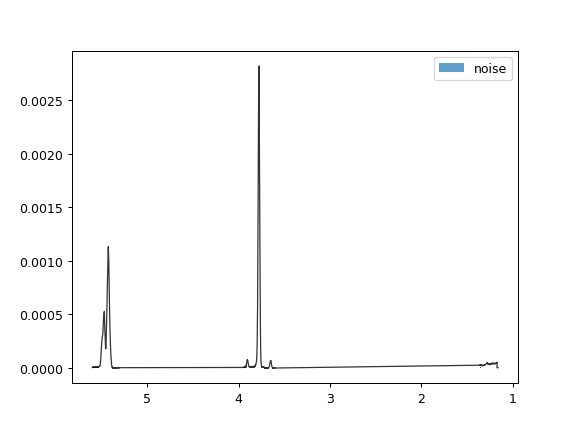

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [139]:
bar_width = np.mean([cha[i]-cha[i-1] for i in range(1, len(cha))])

plt.gca().invert_xaxis()
NMRSpectrum.plot_all([mix], profile=True)
plt.bar(cha, noise, alpha=0.7, label='noise', width=bar_width)
plt.legend()

### Visualisation of removed signal from mixture + spectra of products

In [72]:
best_kappa = 0.1
best_kappa_th = 0.1

In [73]:
with open(results_paths[experiment_name]+'noise_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [74]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    cha = pickle.load(f)
    cha = np.array(cha)

In [75]:
moment_of_time = 1

In [76]:
noise = y[moment_of_time-1,:]

In [90]:
reagents = []
for i, path in enumerate(reagents_paths[experiment_name]):
    reag = pd.read_csv(path, sep = reagents_separators[experiment_name])
    if experiment_name == 'PMG 284 monitoring' and i==2:
        reag.fillna(0, inplace=True)
    sp = NMRSpectrum(confs = list(zip(reag.iloc[:,0], reag.iloc[:,1])))
    sp.normalize()
    reagents.append(sp)

In [92]:
if experiment_name == 'Saccharose hydrolysis':
    products = reagents[-2:]
else:
    products = reagents[-1:]

<IPython.core.display.Javascript object>


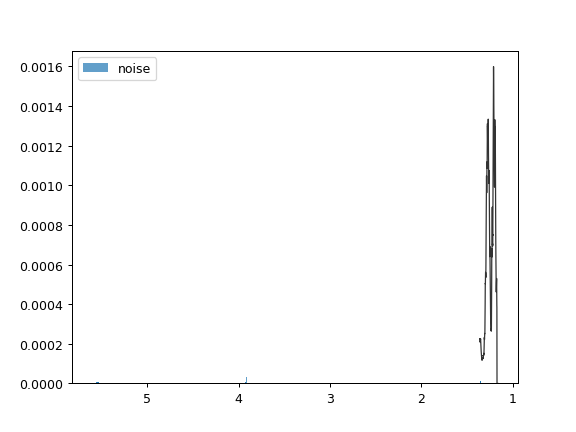

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [107]:
bar_width = np.mean([cha[i]-cha[i-1] for i in range(1, len(cha))])

plt.gca().invert_xaxis()
NMRSpectrum.plot_all(products, profile=True)
plt.bar(cha, noise, alpha=0.7, label='noise', width=bar_width)
plt.legend()

### Visualisation of removed signal in components

This plot will not work for saccharose hydrolysis, because the common mass axis is not saved for this experiment (because it's different for every time point due to baseline correction).

In [95]:
best_kappa = 0.1
best_kappa_th = 1

In [96]:
moment_of_time = 60

In [97]:
components_nrs = [0, 1]

In [98]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)
    current_proportions = y[moment_of_time-1, components_nrs]

In [99]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [100]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    cha = pickle.load(f)
    cha = np.array(cha)

In [101]:
noise_in_components = y[moment_of_time-1,:]

In [102]:
reagents = []
for i, path in enumerate(reagents_paths[experiment_name]):
    reag = pd.read_csv(path, sep = reagents_separators[experiment_name])
    if experiment_name == 'PMG 284 monitoring' and i==2:
        reag.fillna(0, inplace=True)
    sp = NMRSpectrum(confs = list(zip(reag.iloc[:,0], reag.iloc[:,1])))
    sp.normalize()
    reagents.append(sp)

In [103]:
%matplotlib notebook

<IPython.core.display.Javascript object>


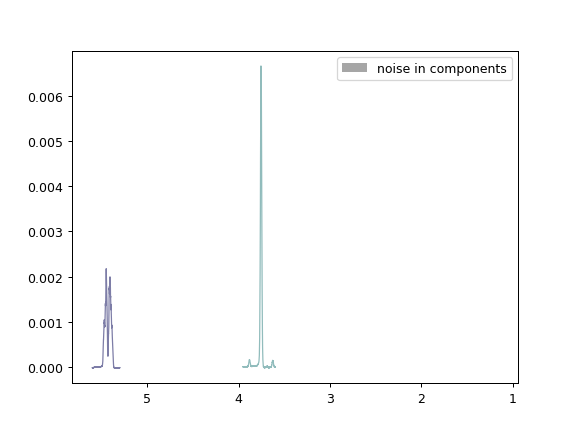

In [106]:
bar_width = np.mean([cha[i]-cha[i-1] for i in range(1, len(cha))])

plt.gca().invert_xaxis()
for i in components_nrs:
    reagents[i].plot(profile=True,
                    color=saturated_colors_for_components[experiment_name][i])
plt.bar(cha, noise_in_components, alpha=0.7, label='noise in components', width=bar_width, color='grey')
plt.legend()

### Mixture and components

In [119]:
reagents = []
for i, path in enumerate(reagents_paths[experiment_name]):
    reag = pd.read_csv(path, sep = reagents_separators[experiment_name])
    sp = NMRSpectrum(confs = list(zip(reag.iloc[:,0], reag.iloc[:,1])))
    sp.normalize()
    reagents.append(sp)

In [120]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [121]:
if experiment_name == 'PMG 284 monitoring':
    mixture_time_data.fillna(0, inplace=True)

In [122]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [123]:
mixture_time_data.columns = names

In [124]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.normalize()
    return sp

<IPython.core.display.Javascript object>


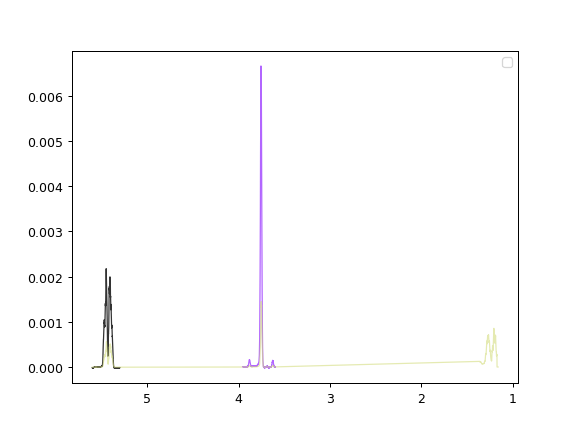

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [125]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents + [load_spectrum(mixture_time_data, 100)], profile=True)

<IPython.core.display.Javascript object>


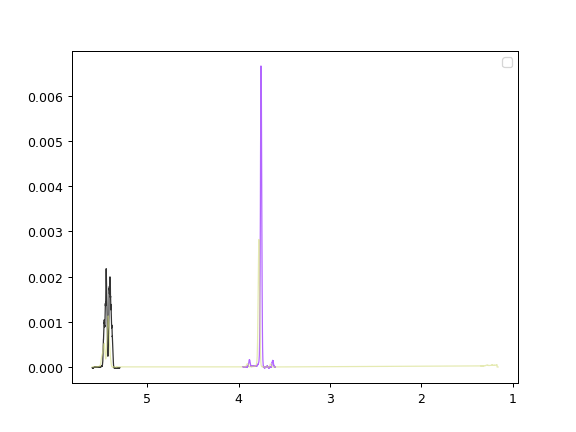

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [126]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents + [load_spectrum(mixture_time_data, 1)], profile=True)